# Machine Learning Analysis - London Housing Data

This notebook will apply supervised ML models from scikit-learn to analyse the real estate data in ```10m_london_houses_.csv```.

Exploratory data analysis of this dataset is covered in ```EDA.ipynb```.

The goal of this notebook is to try out some simple ML models and test best ML practices using a straightforward dataset. This includes
- Apply regression models (Linear, Ridge and Lasso) to predict house prices.
- Perform k-fold cross validation.
- Evaluate model performance with all available metrics: R^2, MSE, RMSE, NMSE confusion matrices.
- Perform hyperparameter tuning with GridSearchCV and RandomSearchCV to optimize models.
- Determine the best regression model for price prediction.
- Convert categoric data to numeric data.
- Evaluate the effect of scaling on model performance.
- Automate model building with pipelines.
- Principal component analysis - [Geeksforgeeks](https://www.geeksforgeeks.org/data-analysis/principal-component-analysis-with-python/)

Repository link: [Github](https://github.com/rsamconn/London-housing)

**Functions created:**
1. `score_predict_plot()` - takes in a dictionary of models, scores them and prints the predictions.
2. `multi_cross_val_score()` - takes in a dictionary of models prints their min--mean--max scores over multiple data folds.
3. `evaluate_CVs()` - takes in a dictionary of models, prints their best scores and parameters and saves these results.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print(np.NaN)

nan


In [2]:
# Load the data
housing_df = pd.read_csv('../data/10m_london_houses_.csv')

# Reminder of how the data looks
print(f"Dataset shape: {housing_df.shape}")
display(housing_df.head())

Dataset shape: (1000, 17)


,Address,Neighborhood,Bedrooms,Bathrooms,Square Meters,Building Age,Garden,Garage,Floors,Property Type,Heating Type,Balcony,Interior Style,View,Materials,Building Status,Price (£)
0,78 Regent Street,Notting Hill,2,3,179,72,No,No,3,Semi-Detached,Electric Heating,High-level Balcony,Industrial,Garden,Marble,Renovated,2291200
1,198 Oxford Street,Westminster,2,1,123,34,Yes,No,1,Apartment,Central Heating,High-level Balcony,Industrial,City,Laminate Flooring,Old,1476000
2,18 Regent Street,Soho,5,3,168,38,No,Yes,3,Semi-Detached,Central Heating,No Balcony,Industrial,Street,Wood,Renovated,1881600
3,39 Piccadilly Circus,Islington,5,1,237,53,Yes,Yes,1,Apartment,Underfloor Heating,No Balcony,Classic,Park,Granite,Renovated,1896000
4,116 Fleet Street,Marylebone,4,1,127,23,No,Yes,2,Semi-Detached,Central Heating,No Balcony,Modern,Park,Wood,Old,1524000


## Planning

I will run Regression models for several different 'passes' which each use different feature datasets.

Each pass gets these steps:

1. Subset data and create test-train sets
2. Simple models - fit, score, plot predictions
3. K-fold cross validation
4. Hyperparameter tuning
5. Scaling
6. Principal component analysis (PCA)
7. Summary

Passes:
- [x] Pass 1 = only square meters
- [x] Pass 2 = only numeric data
- [x] Pass 3 = numeric data plus data from the Neighborhood column
- [x] Pass 4 = _all_ data
- [x] Pass 5 = use only the top features from PCA

Other ideas: add price per square meter column, add other features?

In [3]:
from sklearn.model_selection import train_test_split

# Import models
from sklearn.linear_model import LinearRegression, Lasso, Ridge

***
## Pass 1 - Only Square Meters
***
1. Get data
2. Simple test models - pick 1 hyperparam, instantiate, fit, score, predict and plot predictions
3. k-fold cross validation - setup k-Fold data, apply `cross_val_score`, boxplot the results
4. Hyperparameter tuning - setup param grids, setup RandomizedSearchCV object, fit, print score, best score and best params

### 1.1 Get data

In [4]:
# Create sqm-only dataset
X_sqm = housing_df['Square Meters'].values.reshape(-1, 1)
y = housing_df['Price (£)'].values
X_train_sqm, X_test_sqm, y_train_sqm, y_test_sqm = train_test_split(X_sqm, y, test_size=0.3, random_state=24)

print(X_train_sqm.shape, X_test_sqm.shape, y_train_sqm.shape, y_test_sqm.shape)

(700, 1) (300, 1) (700,) (300,)


### 1.2 Simple models

#### 1.2.1 Instantiate and fit

In [5]:
# Instantiate models
linreg_sqm = LinearRegression()
lasso_sqm = Lasso(alpha = 0.1)
ridge_sqm = Ridge(alpha = 0.1)

# Fit to numeric data
linreg_sqm.fit(X_train_sqm, y_train_sqm)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [6]:
lasso_sqm.fit(X_train_sqm, y_train_sqm)


,alpha,0.1
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [7]:
ridge_sqm.fit(X_train_sqm, y_train_sqm)

,alpha,0.1
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [8]:
# Create a model dictionary
models_sqm = {
    'Linear Regression (sqm)': linreg_sqm,
    'Lasso (sqm)': lasso_sqm,
    'Ridge (sqm)': ridge_sqm
}

#### 1.2.2 Predict and plot

In [9]:
def score_predict_plot(model_dict,
                       X_train, y_train, X_test, y_test, X_test1D,
                       title='Model predictions'):
    """Evaluate multiple models and plot their predictions vs actual values."""
    
    # Create figure and plot the actual results
    plt.figure(figsize=(10, 6))
    plt.scatter(X_test1D, y_test, label='Actual', color='black', marker='D', alpha=0.9, s=20)
    
    # Loop over models and plot their restults
    for model_name, model in model_dict.items():
        
        y_pred = model.predict(X_test)

        # Plot predicted results
        plt.scatter(X_test1D, y_pred, label=model_name, alpha=0.5, s=20)
        train_score = model.score(X_train, y_train)
        test_score = model.score(X_test, y_test)

        print(f"{model_name} training--testing R²: {train_score:.4f}--{test_score:.4f}")
        # print(f"{model_name} training--testing MSE: {train_score/len(y_train):.4f}--{test_score/len(y_test):.4f}")
        # print(f"{model_name} training--testing RMSE: {np.sqrt(train_score/len(y_train)):.4f}--{np.sqrt(test_score/len(y_test)):.4f}")
        
    plt.xlabel('Square meters [m^2]', fontsize=11)
    plt.ylabel('Price [£]', fontsize=11)
    plt.title(title, fontsize=12, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

Linear Regression (sqm) training--testing R²: 0.6391--0.5912
Lasso (sqm) training--testing R²: 0.6391--0.5912
Ridge (sqm) training--testing R²: 0.6391--0.5912


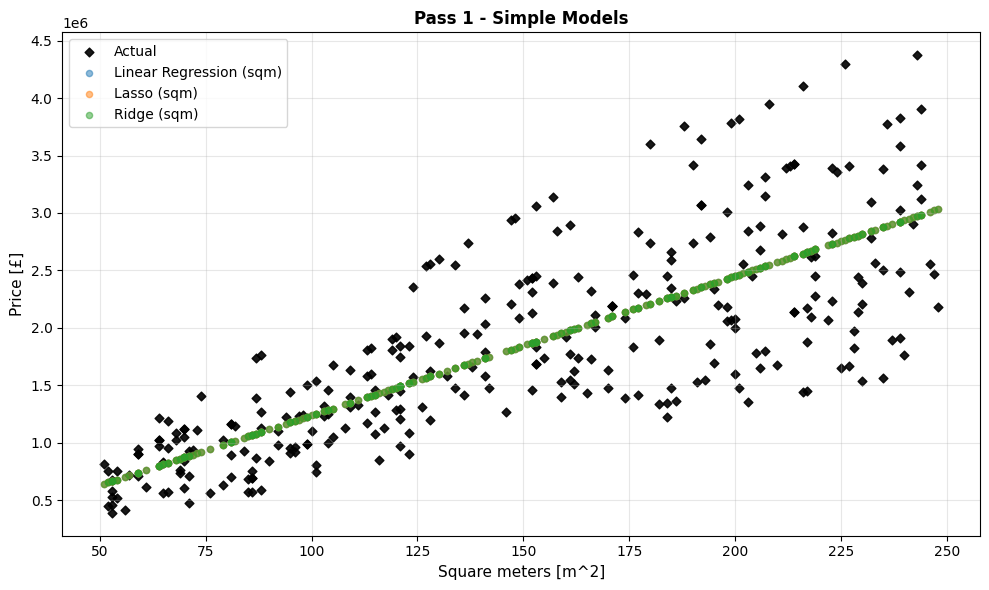

In [10]:
score_predict_plot(models_sqm,
                   X_train_sqm, y_train_sqm, X_test_sqm, y_test_sqm, X_test_sqm,
                   title='Pass 1 - Simple Models')

### 1.3 Cross validation

- Create a k-fold dataset
- Fit and print min-mean-max
- Boxplot the results

In [11]:
# Create k-fold object
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
kf5 = KFold(n_splits=5, shuffle=True, random_state=24)
kf10 = KFold(n_splits=10, shuffle=True, random_state=24)

In [12]:
def multi_cross_val_score(models, X, y, kf, score_method='r2'):
    """Function to return cross-validation scores for multiple models."""
    cross_val_scores = {}
    for name, model in models.items():
        scores = cross_val_score(model, X, y, cv=kf, scoring=score_method)
        # if score_method:
        #     scores = cross_val_score(model, X, y, cv=kf, scoring=score_method)
        # else:
        #     scores = cross_val_score(model, X, y, cv=kf)
        cross_val_scores[name] = scores
        print(f'{name} cross-validation scores: {np.min(scores):.3f} --- {np.mean(scores):.3f} --- {np.max(scores):.3f}')
    return cross_val_scores

In [13]:
cross_vals_sqm_train = multi_cross_val_score(
    models = {'Linear Regression': linreg_sqm, 'Lasso': lasso_sqm, 'Ridge': ridge_sqm},
    X = X_train_sqm,
    y = y_train_sqm,
    kf = kf10
)

Linear Regression cross-validation scores: 0.526 --- 0.630 --- 0.698
Lasso cross-validation scores: 0.526 --- 0.630 --- 0.698
Ridge cross-validation scores: 0.526 --- 0.630 --- 0.698


In [14]:
cross_vals_sqm_test = multi_cross_val_score(
    models = {'Linear Regression': linreg_sqm, 'Lasso': lasso_sqm, 'Ridge': ridge_sqm},
    X = X_test_sqm,
    y = y_test_sqm,
    kf = kf10
)

Linear Regression cross-validation scores: 0.382 --- 0.555 --- 0.695
Lasso cross-validation scores: 0.382 --- 0.555 --- 0.695
Ridge cross-validation scores: 0.382 --- 0.555 --- 0.695


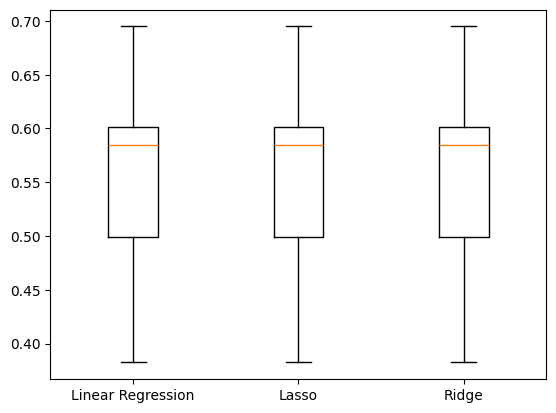

In [15]:
plt.boxplot(
    [model_result for model_result in cross_vals_sqm_test.values()],
    labels = [model_name for model_name in cross_vals_sqm_test.keys()]
)
plt.show()

### 1.4 Hyperparameter tuning

Function to fit and evaluates CV objects.

In [16]:
def evaluate_CVs(models, X_train, y_train):
    '''Fit CV objects from a dictionary.
    Print best scores and parameters and save them to a new dict.'''
    results_dict = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        print('{} {} {}'.format(5*'-', name, 5*'-'))
        # print(f'{name} score: {model.score(X, y)}')
        print(f'Top score: {model.best_score_:.4f}')
        print(f'Top params: {model.best_params_}')
        results_dict[name] = [model.best_score_, model.best_params_]
    return results_dict

In [17]:
lasso_params = {'alpha': np.linspace(0.001, 10)}
ridge_params = {'alpha': np.linspace(0.001, 10),
                'solver': ['sag', 'lsqr']}

Instantiate Models

In [18]:
# Instantiate GridSearchCVs
gridCV_lasso_sqm = GridSearchCV(lasso_sqm, lasso_params, cv=kf10)
gridCV_ridge_sqm = GridSearchCV(ridge_sqm, ridge_params, cv=kf10)
# Instantiate RandomizedSearchCVs
randomCV_lasso_sqm = RandomizedSearchCV(lasso_sqm, lasso_params, cv=kf10, n_iter=10, random_state=24)
randomCV_ridge_sqm = RandomizedSearchCV(ridge_sqm, ridge_params, cv=kf10, n_iter=10, random_state=24)
# Save models to dictionary
cvs_sqm = {'Lasso GridSearchCV': gridCV_lasso_sqm,
            'Ridge GridSearchCV': gridCV_ridge_sqm,
            'Lasso RandomizedSearchCV': randomCV_lasso_sqm,
            'Ridge RandomizedSearchCV': randomCV_ridge_sqm,}

Evaluate models

In [19]:
cv_results_sqm = evaluate_CVs(cvs_sqm, X_train_sqm, y_train_sqm)

----- Lasso GridSearchCV -----
Top score: 0.6296
Top params: {'alpha': 10.0}
----- Ridge GridSearchCV -----
Top score: 0.6303
Top params: {'alpha': 2.0416122448979594, 'solver': 'sag'}
----- Lasso RandomizedSearchCV -----
Top score: 0.6296
Top params: {'alpha': 8.163448979591838}
----- Ridge RandomizedSearchCV -----
Top score: 0.6296
Top params: {'solver': 'sag', 'alpha': 7.755326530612246}


### 1.5 Scaling
Can the score be increased through Standard Scaling?

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

steps_ridge = [
    ('scaler', StandardScaler()),
    ('ridge', Ridge()),
]

pipeline_ridge_sqm = Pipeline(steps_ridge)

ridge_sqm_scaled = pipeline_ridge_sqm.fit(X_train_sqm, y_train_sqm)

In [21]:
ridge_sqm_scaled.score(X_test_sqm, y_test_sqm)

0.5913154197136332

Adding in CVs

In [22]:
lasso_params2 = {'alpha': np.linspace(0.0001, 1, 10)}
ridge_params2 = {'ridge__alpha': np.linspace(0.0001, 1, 10),
                'ridge__solver': ['sag', 'lsqr']}

In [23]:
# Instantiate GridSearchCVs
gridCV_ridge_sqm_scaled = GridSearchCV(ridge_sqm_scaled, param_grid=ridge_params2, cv=kf10)
# Fit GridSearchCVs
gridCV_ridge_sqm_scaled.fit(X_train_sqm, y_train_sqm)

# Score GridSearchCV models
print(f'Ridge score: {gridCV_ridge_sqm_scaled.score(X_test_sqm, y_test_sqm)}')
print(f'Scaled Ridge GridSearchCV top score: {gridCV_ridge_sqm_scaled.best_score_} from {gridCV_ridge_sqm_scaled.best_params_}')

Ridge score: 0.591236916141018
Scaled Ridge GridSearchCV top score: 0.6296183231143576 from {'ridge__alpha': 0.6667000000000001, 'ridge__solver': 'sag'}


### 1.6 Pass 1 - Summary
What have we learned?

1. Simple models: each of Linear, Lasso and Ridge Regression each get 59% accuracy --> Quite poor
    - Each model seems to be making exactly the same predictions
2. 5-Fold cross-validation: the scores range from 59-66% (average 63%)
3. 10-Fold cross-validation: the scores range from 53-70% (average 63%)
4. GridSearchCV over alpha: best parameters get 63% at alpha=1 (Ridge and Lasso are equal, RandomizedSearchCV gives basically the same results)
5. Nothing gained from scaling

***
## Pass 2 - Numeric data
***
Now include the numbers of bedrooms, bathrooms, floors and the building age in the feature set.

### 2.1 Get Data

In [24]:
# Create numeric-only dataset
numeric_columns = ['Bedrooms', 'Bathrooms', 'Square Meters', 'Building Age', 'Floors']
X_numeric = housing_df.loc[:, numeric_columns].values
y = housing_df['Price (£)'].values
X_train_numeric, X_test_numeric, y_train_numeric, y_test_numeric = train_test_split(X_numeric, y, test_size=0.3, random_state=24)

print(X_train_numeric.shape, X_test_numeric.shape, y_train_numeric.shape, y_test_numeric.shape)

(700, 5) (300, 5) (700,) (300,)


### 2.2 Simple Models

#### 2.2.1 Import, instantiate, fit

Linear, lasso and ridge regression model

In [25]:
# Instantiate models
linreg_num = LinearRegression()
lasso_num = Lasso(alpha = 0.1)
ridge_num = Ridge(alpha = 0.1)

# Fit to numeric data
linreg_num.fit(X_train_numeric, y_train_numeric)
lasso_num.fit(X_train_numeric, y_train_numeric)
ridge_num.fit(X_train_numeric, y_train_numeric)

,alpha,0.1
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [26]:
# Create a dictionary of numeric models
models_numeric = {
    'Linear Regression (numeric)': linreg_num,
    'Lasso (numeric)': lasso_num,
    'Ridge (numeric)': ridge_num
}

#### 2.2.2 Predict

Linear Regression (numeric) training--testing R²: 0.6400--0.5901
Lasso (numeric) training--testing R²: 0.6400--0.5901
Ridge (numeric) training--testing R²: 0.6400--0.5901


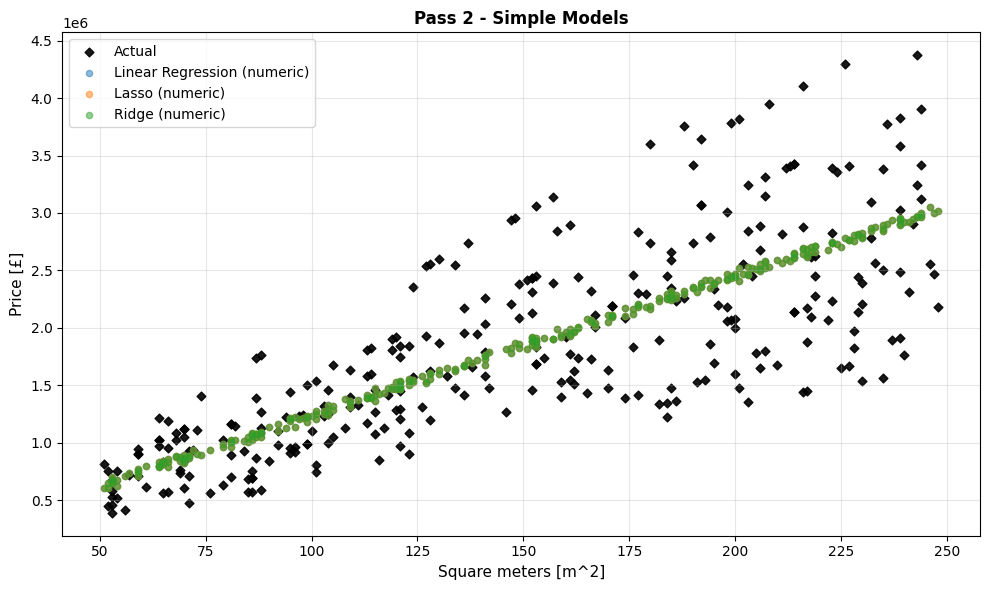

In [27]:
score_predict_plot(models_numeric,
                   X_train_numeric, y_train_numeric, X_test_numeric, y_test_numeric,
                   X_test_sqm, title='Pass 2 - Simple Models')

### 2.3 Cross validation - Numeric

- Create a k-fold dataset
- Fit and print min-mean-max
- Boxplot the results

Training set scores

In [28]:
cross_vals_num_train = multi_cross_val_score(
    models = models_numeric,
    X = X_train_numeric,
    y = y_train_numeric,
    kf = kf10
)

Linear Regression (numeric) cross-validation scores: 0.526 --- 0.627 --- 0.698
Lasso (numeric) cross-validation scores: 0.526 --- 0.627 --- 0.698
Ridge (numeric) cross-validation scores: 0.526 --- 0.627 --- 0.698


Test set scores

In [29]:
cross_vals_num_test = multi_cross_val_score(
    models = models_numeric,
    X = X_test_numeric,
    y = y_test_numeric,
    kf = kf10
)

Linear Regression (numeric) cross-validation scores: 0.362 --- 0.547 --- 0.685
Lasso (numeric) cross-validation scores: 0.362 --- 0.547 --- 0.685
Ridge (numeric) cross-validation scores: 0.362 --- 0.547 --- 0.685


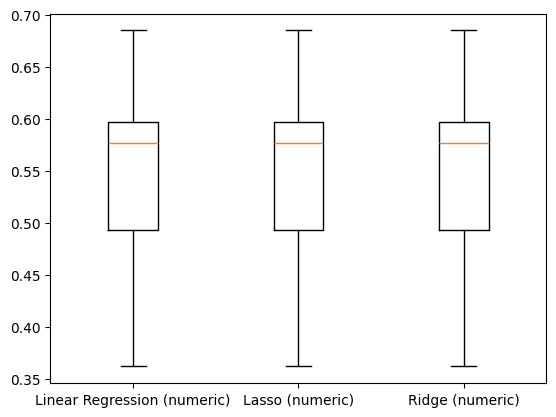

In [30]:
plt.boxplot(
    [model_result for model_result in cross_vals_num_test.values()],
    labels = [model_name for model_name in cross_vals_num_test.keys()]
)
plt.show()

### 2.4 Hyperparameter Tuning - Numeric
Run GridSearchCV and RandomizedSearchCV on the numeric models.

In [31]:
lasso_params3 = {'alpha': np.linspace(0.001, 100, 20)}
ridge_params3 = {'alpha': np.linspace(0.001, 100, 20),
                'solver': ['sag', 'lsqr']}

In [32]:
# Instantiate GridSearchCVs
gridCV_lasso_num = GridSearchCV(lasso_num, lasso_params3, cv=kf10)
gridCV_ridge_num = GridSearchCV(ridge_num, ridge_params3, cv=kf10)
# Instantiate RandomizedSearchCVs
randomCV_lasso_num = RandomizedSearchCV(lasso_num, lasso_params3, cv=kf10, n_iter=20, random_state=24)
randomCV_ridge_num = RandomizedSearchCV(ridge_num, ridge_params3, cv=kf10, n_iter=20, random_state=24)
# Save models to dictionary
cvs_num = {'Lasso GridSearchCV': gridCV_lasso_num,
           'Ridge GridSearchCV': gridCV_ridge_num,
           'Lasso RandomizedSearchCV': randomCV_lasso_num, 
           'Ridge RandomizedSearchCV': randomCV_ridge_num,}

In [33]:
cv_results_num = evaluate_CVs(cvs_num, X_train_numeric, y_train_numeric)

----- Lasso GridSearchCV -----
Top score: 0.6267
Top params: {'alpha': 100.0}
----- Ridge GridSearchCV -----
Top score: 0.6271
Top params: {'alpha': 100.0, 'solver': 'lsqr'}
----- Lasso RandomizedSearchCV -----
Top score: 0.6267
Top params: {'alpha': 100.0}
----- Ridge RandomizedSearchCV -----
Top score: 0.6271
Top params: {'solver': 'lsqr', 'alpha': 100.0}


### 2.5 Scaling - numeric data

In [34]:
pipeline_ridge_num = Pipeline(steps_ridge)

ridge_num_scaled = pipeline_ridge_num.fit(X_train_numeric, y_train_numeric)

In [35]:
ridge_num_scaled.score(X_test_numeric, y_test_numeric)

0.5901869473795919

In [36]:
# Create a RandomizedSearchCV with pipelines
ridge_num_params = {'ridge__alpha': np.linspace(0.0001, 1, 100),
                         'ridge__solver': ['sag', 'lsqr']}
randomCV_ridge_num_scaled = RandomizedSearchCV(pipeline_ridge_num, param_distributions=ridge_num_params, cv=kf10, n_iter=20, random_state=24)

randomCV_ridge_num_scaled.fit(X_train_numeric, y_train_numeric)

,estimator,"Pipeline(step...e', Ridge())])"
,param_distributions,"{'ridge__alpha': array([1.000e...1, 1.000e+00]), 'ridge__solver': ['sag', 'lsqr']}"
,n_iter,20
,scoring,None
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,24
,error_score,nan


In [37]:
# Score RandomizedSearchCV models
print(f'Ridge score: {randomCV_ridge_num_scaled.score(X_test_numeric, y_test_numeric)}')
print(f'Scaled Ridge GridSearchCV top score: {randomCV_ridge_num_scaled.best_score_} from {randomCV_ridge_num_scaled.best_params_}')

Ridge score: 0.590177624900116
Scaled Ridge GridSearchCV top score: 0.626779409560169 from {'ridge__solver': 'sag', 'ridge__alpha': 0.9595999999999999}


### 2.6 PCA with Lasso
Plot the importance of different features with Lasso Regression.
#### 2.6.1 Before Scaling

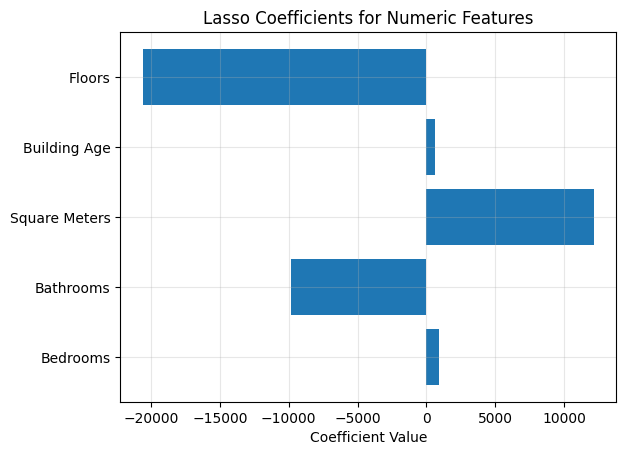

In [38]:
lasso_num_coeff = Lasso(alpha=0.1).fit(X_train_numeric, y_train_numeric).coef_

plt.barh(numeric_columns, lasso_num_coeff)
plt.xlabel('Coefficient Value')
plt.title('Lasso Coefficients for Numeric Features')
plt.grid(True, alpha=0.3)
plt.show()

#### 2.6.2 After Scaling

In [39]:
scaler1 = StandardScaler()
scaled_data_num = scaler1.fit_transform(X_train_numeric)

PCA after scaling

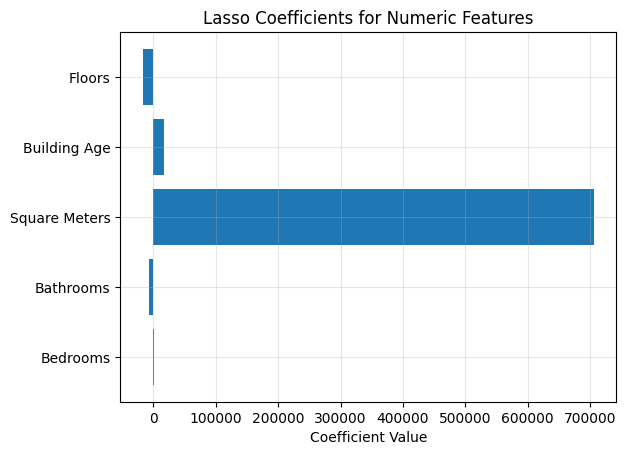

In [40]:
lasso_num_coeff_scaled = Lasso(alpha=0.1).fit(scaled_data_num, y_train_numeric).coef_

plt.barh(numeric_columns, lasso_num_coeff_scaled)
plt.xlabel('Coefficient Value')
plt.title('Lasso Coefficients for Numeric Features')
plt.grid(True, alpha=0.3)
plt.show()

### 2.7 Summary
1. Simple models - same performance as when using just Square Meters (R2=0.59)
2. Cross-validation - same performance as... ()
3. Hyperparameter tuning - same performance as...
4. Scaling - nothing gained
5. PCA - as expected Square Meters has the biggest effect after scaling (if you don't apply scaling then floors and bathrooms have massive negative coefficients).
6. Lasso, Ridge and LinReg still all the same

***
## Pass 3 - Adding Neighbourhood data
***
As well as the numeric data, we now add categoric data: the neighbourhood of each house.

This requires converting the categoric data to numeric data.

This is expected to improve accuracy - from the EDA, the neighbourhoods were quite strongly correlated to the Price.

### 3.1 Get Data
How many instances are there of each neighborhood?

In [41]:
print(housing_df['Neighborhood'].unique())
for neighborhood in housing_df['Neighborhood'].unique():
    print(f'{neighborhood}: {len(housing_df[housing_df["Neighborhood"] == neighborhood])}')

['Notting Hill' 'Westminster' 'Soho' 'Islington' 'Marylebone' 'Kensington'
 'Greenwich' 'Shoreditch' 'Camden' 'Chelsea']
Notting Hill: 96
Westminster: 98
Soho: 96
Islington: 97
Marylebone: 113
Kensington: 114
Greenwich: 97
Shoreditch: 89
Camden: 106
Chelsea: 94


Create dummy variables for the neighborhood columns.

In [42]:
neighborhoods = housing_df['Neighborhood'].unique()
print(neighborhoods, len(neighborhoods))

# Create dummy variables for neighborhoods
neighborhood_dummies = pd.get_dummies(housing_df['Neighborhood'], drop_first=True).astype('int')
# Combine with df of numeric variables
neighbor_numeric_df = pd.concat([housing_df[numeric_columns], neighborhood_dummies], axis=1)
neighbor_numeric_df.head()

['Notting Hill' 'Westminster' 'Soho' 'Islington' 'Marylebone' 'Kensington'
 'Greenwich' 'Shoreditch' 'Camden' 'Chelsea'] 10


,Bedrooms,Bathrooms,Square Meters,Building Age,Floors,Chelsea,Greenwich,Islington,Kensington,Marylebone,Notting Hill,Shoreditch,Soho,Westminster
0,2,3,179,72,3,0,0,0,0,0,1,0,0,0
1,2,1,123,34,1,0,0,0,0,0,0,0,0,1
2,5,3,168,38,3,0,0,0,0,0,0,0,1,0
3,5,1,237,53,1,0,0,1,0,0,0,0,0,0
4,4,1,127,23,2,0,0,0,0,1,0,0,0,0


Create test and training data

In [43]:
X_train_neighbor, X_test_neighbor, y_train_neighbor, y_test_neighbor = train_test_split(neighbor_numeric_df, y, test_size=0.3, random_state=24)

print(X_train_neighbor.shape, X_test_neighbor.shape, y_train_neighbor.shape, y_test_neighbor.shape)

(700, 14) (300, 14) (700,) (300,)


### 3.2 Simple Models

#### 3.2.1 Import, instantiate, fit

Linear, lasso and ridge regression model

In [44]:
# Instantiate models
linreg_neighbor = LinearRegression()
lasso_neighbor = Lasso(alpha = 0.1)
ridge_neighbor = Ridge(alpha = 0.1)

# Fit to neighbor data
linreg_neighbor.fit(X_train_neighbor, y_train_neighbor)
lasso_neighbor.fit(X_train_neighbor, y_train_neighbor)
ridge_neighbor.fit(X_train_neighbor, y_train_neighbor)

,alpha,0.1
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [45]:
# Create a dictionary of neighboreric models
models_neighbor = {
    'Linear Regression (neighbor)': linreg_neighbor,
    'Lasso (neighbor)': lasso_neighbor,
    'Ridge (neighbor)': ridge_neighbor
}

#### 3.2.2 Predict & Plot

Linear Regression (neighbor) training--testing R²: 0.8325--0.8249
Lasso (neighbor) training--testing R²: 0.8325--0.8249
Ridge (neighbor) training--testing R²: 0.8325--0.8247


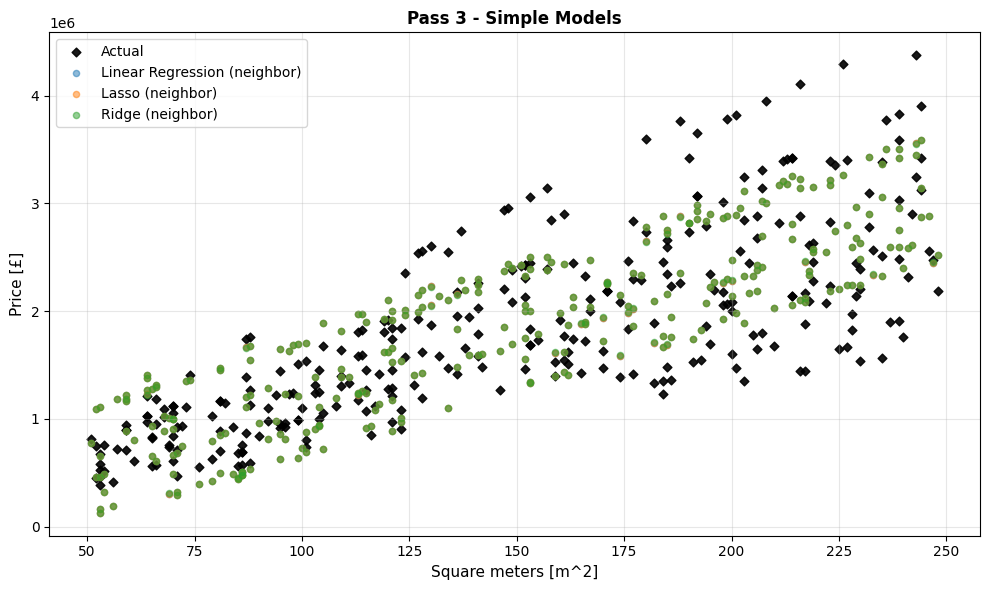

In [46]:
score_predict_plot(models_neighbor,
                   X_train_neighbor, y_train_neighbor, X_test_neighbor, y_test_neighbor,
                   X_test_sqm, title='Pass 3 - Simple Models')

### 3.3 Cross validation
Training set scores

In [47]:
cross_vals_neighbor_train = multi_cross_val_score(
    models = models_neighbor,
    X = X_train_neighbor,
    y = y_train_neighbor,
    kf = kf10
)

Linear Regression (neighbor) cross-validation scores: 0.780 --- 0.822 --- 0.872
Lasso (neighbor) cross-validation scores: 0.780 --- 0.822 --- 0.872
Ridge (neighbor) cross-validation scores: 0.780 --- 0.822 --- 0.872


Test set scores

In [48]:
cross_vals_neighbor_test = multi_cross_val_score(
    models = models_neighbor,
    X = X_test_neighbor,
    y = y_test_neighbor,
    kf = kf10
)

Linear Regression (neighbor) cross-validation scores: 0.769 --- 0.808 --- 0.857
Lasso (neighbor) cross-validation scores: 0.769 --- 0.808 --- 0.857
Ridge (neighbor) cross-validation scores: 0.768 --- 0.808 --- 0.858


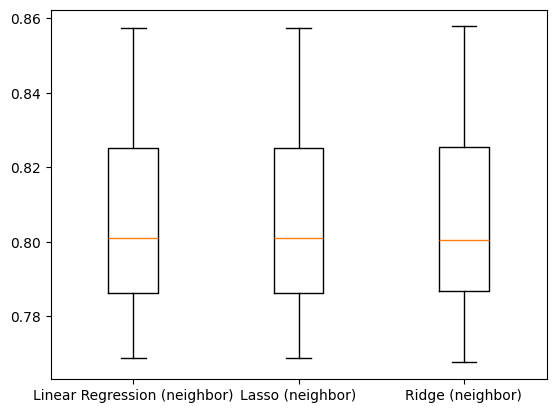

In [49]:
plt.boxplot(
    [model_result for model_result in cross_vals_neighbor_test.values()],
    labels = [model_name for model_name in cross_vals_neighbor_test.keys()]
)
plt.show()

### 3.4 Hyperparameter Tuning

For this data, the Ridge model fails to converge so is commented out here.

In [50]:
# Instantiate GridSearchCVs
gridCV_lasso_neighbor = GridSearchCV(lasso_neighbor, lasso_params, cv=kf10)
gridCV_ridge_neighbor = GridSearchCV(lasso_neighbor, ridge_params, cv=kf10)
# Instantiate RandomizedSearchCVs
randomCV_lasso_neighbor = RandomizedSearchCV(lasso_neighbor, lasso_params, cv=kf10, n_iter=10, random_state=24)
# randomCV_ridge_neighbor = RandomizedSearchCV(ridge_neighbor, ridge_params, cv=kf10, n_iter=10, random_state=24)
# Save models to dictionary
cvs_neighbor = {'Lasso GridSearchCV': gridCV_lasso_neighbor,
                # 'Ridge GridSearchCV': gridCV_ridge_neighbor,
                'Lasso RandomizedSearchCV': randomCV_lasso_neighbor,
                # 'Ridge RandomizedSearchCV': randomCV_ridge_neighbor
                }

In [51]:
cv_results_neighbor = evaluate_CVs(cvs_neighbor, X_train_neighbor, y_train_neighbor)

----- Lasso GridSearchCV -----
Top score: 0.8222
Top params: {'alpha': 10.0}
----- Lasso RandomizedSearchCV -----
Top score: 0.8222
Top params: {'alpha': 8.163448979591838}


### 3.5 Scaling

In [52]:
pipeline_ridge_neighbor = Pipeline(steps_ridge)

ridge_neighbor_scaled = pipeline_ridge_neighbor.fit(X_train_neighbor, y_train_neighbor)

In [53]:
ridge_neighbor_scaled.score(X_test_neighbor, y_test_neighbor)

0.8248280330569018

In [54]:
# Create a RandomizedSearchCV with pipelines
ridge_neighbor_params = {'ridge__alpha': np.linspace(0.001, 10, 100),
                         'ridge__solver': ['sag', 'lsqr']}
randomCV_ridge_neighbor_scaled = RandomizedSearchCV(pipeline_ridge_neighbor, param_distributions=ridge_neighbor_params,
                                                    cv=kf10, n_iter=20, random_state=24)

randomCV_ridge_neighbor_scaled.fit(X_train_neighbor, y_train_neighbor)

,estimator,"Pipeline(step...e', Ridge())])"
,param_distributions,"{'ridge__alpha': array([1.000e...0, 1.000e+01]), 'ridge__solver': ['sag', 'lsqr']}"
,n_iter,20
,scoring,None
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,24
,error_score,nan


In [55]:
cv_results_neighbor_scaled = evaluate_CVs(cvs_neighbor, X_train_neighbor, y_train_neighbor)

----- Lasso GridSearchCV -----
Top score: 0.8222
Top params: {'alpha': 10.0}
----- Lasso RandomizedSearchCV -----
Top score: 0.8222
Top params: {'alpha': 8.163448979591838}


### 3.6 PCA
Before scaling

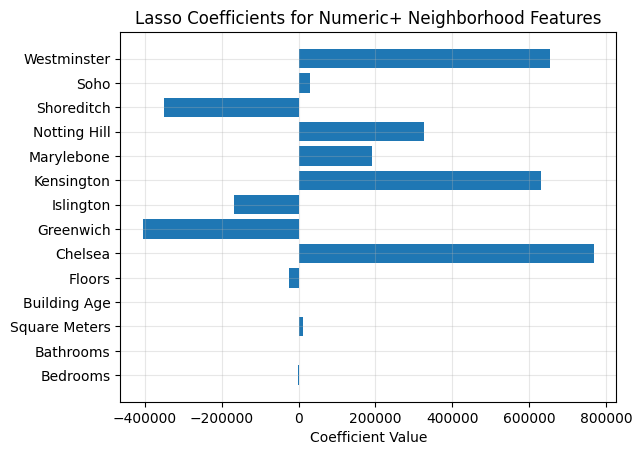

In [56]:
lasso_coeff_neighbor = Lasso(alpha = 0.1).fit(X_train_neighbor, y_train_neighbor).coef_

# lasso_coeff_neighbor
# X_train_neighbor.columns
plt.barh(X_train_neighbor.columns, lasso_coeff_neighbor)
plt.xlabel('Coefficient Value')
plt.title('Lasso Coefficients for Numeric+ Neighborhood Features')
plt.grid(True, alpha=0.3)
plt.show()

After scaling

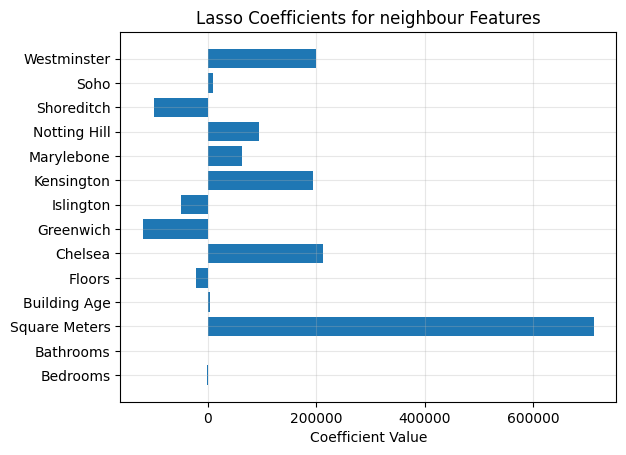

In [57]:
scaled_neighbor = scaler1.fit_transform(X_train_neighbor)
lasso_coeff_neighbor_scaled = Lasso(alpha = 0.1).fit(scaled_neighbor, y_train_neighbor).coef_

plt.barh(X_train_neighbor.columns, lasso_coeff_neighbor_scaled)
plt.xlabel('Coefficient Value')
plt.title('Lasso Coefficients for neighbour Features')
plt.grid(True, alpha=0.3)
plt.show()

### 3.7 Summary
1. Neighborhood data - around 90-110 for each of the 10 neighborhoods
2. Simple models - already a ~20% improvement from using numeric data (R^2=0.82).
3. Cross-validation - R^2 range of 0.78-0.87: ~20% improvement on numeric data.
4. Hyperparameter Tuning
    - Best performance of R^2=0.82 for GridSearchCV and RandomizedSearchCV
    - Ridge model has problems with convergence, likely due to the sparse neighborhood data.
5. Scaling - Accuracy is unchanged by scaling but the Ridge model is now able to converge.
6. PCA - Before scaling the neighborhood features have the largest coefficients - after scaling square meters is again back to the top (twice as high as the highest neighborhood coefficient), but neighborhood features still have significantly higher coefficients than the other numeric columns.


***
## Pass 4 - Adding all remaining
***
Finally we include all other categoric columns (except Address)

### 4.1 Get Data
We create dummy variables for the remaining columns: bedrooms, bathrooms, building age, garden, garage, floors, property type, heating type, baclony, interior style, view, materials, building status.

Let's check what unique values each categoric column has:

In [58]:
categoric_columns = ['Neighborhood', 'Garden', 'Garage', 'Property Type',
                     'Heating Type', 'Balcony', 'Interior Style', 'View',
                     'Materials', 'Building Status']
# Print unique values for each categoric column
for col in categoric_columns:
    print(f'\'{col}\' {len(housing_df[col].unique())} values: {housing_df[col].unique()}')

'Neighborhood' 10 values: ['Notting Hill' 'Westminster' 'Soho' 'Islington' 'Marylebone' 'Kensington'
 'Greenwich' 'Shoreditch' 'Camden' 'Chelsea']
'Garden' 2 values: ['No' 'Yes']
'Garage' 2 values: ['No' 'Yes']
'Property Type' 3 values: ['Semi-Detached' 'Apartment' 'Detached House']
'Heating Type' 4 values: ['Electric Heating' 'Central Heating' 'Underfloor Heating' 'Gas Heating']
'Balcony' 3 values: ['High-level Balcony' 'No Balcony' 'Low-level Balcony']
'Interior Style' 4 values: ['Industrial' 'Classic' 'Modern' 'Minimalist']
'View' 5 values: ['Garden' 'City' 'Street' 'Park' 'Sea']
'Materials' 4 values: ['Marble' 'Laminate Flooring' 'Wood' 'Granite']
'Building Status' 3 values: ['Renovated' 'Old' 'New']


Create dataframe with dummy variables.

In [59]:
# Create dummy variables and convert them to integers
categoric_dummies = pd.get_dummies(housing_df[categoric_columns], drop_first=True).astype('int')
all_df = pd.concat([housing_df[numeric_columns], categoric_dummies], axis=1)
all_df.head()

,Bedrooms,Bathrooms,Square Meters,Building Age,Floors,Neighborhood_Chelsea,Neighborhood_Greenwich,Neighborhood_Islington,Neighborhood_Kensington,Neighborhood_Marylebone,...,Interior Style_Modern,View_Garden,View_Park,View_Sea,View_Street,Materials_Laminate Flooring,Materials_Marble,Materials_Wood,Building Status_Old,Building Status_Renovated
0,2,3,179,72,3,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
1,2,1,123,34,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,5,3,168,38,3,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1
3,5,1,237,53,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
4,4,1,127,23,2,0,0,0,0,1,...,1,0,1,0,0,0,0,1,1,0


Create test and training data

In [60]:
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(all_df, y, test_size=0.3, random_state=24)

print(X_train_all.shape, X_test_all.shape, y_train_all.shape, y_test_all.shape)

(700, 35) (300, 35) (700,) (300,)


### 4.2 Simple Models
#### 4.2.1 Import, instantiate, fit

Lasso fails to converge here so is commented out.

In [61]:
# Instantiate models
linreg_all = LinearRegression()
lasso_all = Lasso(alpha = 0.1)
ridge_all = Ridge(alpha = 0.1)

# Fit to all data
linreg_all.fit(X_train_all, y_train_all)
# lasso_all.fit(X_train_all, y_train_all)
ridge_all.fit(X_train_all, y_train_all)

,alpha,0.1
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [62]:
# Create a dictionary of alleric models
models_all = {
    'Linear Regression (all)': linreg_all,
    # 'Lasso': lasso_all,
    'Ridge (all)': ridge_all
}

#### 4.2.2 Predict & Plot

Linear Regression (all) training--testing R²: 0.9498--0.9430
Ridge (all) training--testing R²: 0.9498--0.9430


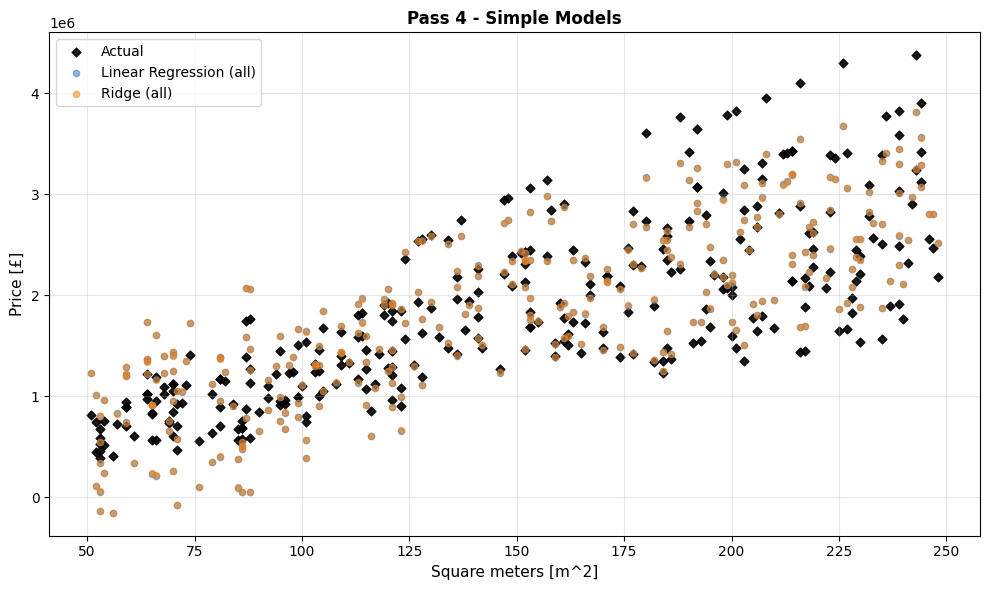

In [63]:
score_predict_plot(models_all,
                   X_train_all, y_train_all, X_test_all, y_test_all,
                   X_test_sqm, title='Pass 4 - Simple Models')

### 4.3 Cross validation
Training set scores

In [64]:
cross_vals_all_train = multi_cross_val_score(
    models = models_all,
    X = X_train_all,
    y = y_train_all,
    kf = kf10
)

Linear Regression (all) cross-validation scores: 0.916 --- 0.943 --- 0.959
Ridge (all) cross-validation scores: 0.916 --- 0.943 --- 0.959


Test set secores

In [65]:
cross_vals_all_test = multi_cross_val_score(
    models = models_all,
    X = X_test_all,
    y = y_test_all,
    kf = kf10
)

Linear Regression (all) cross-validation scores: 0.912 --- 0.935 --- 0.953
Ridge (all) cross-validation scores: 0.912 --- 0.935 --- 0.952


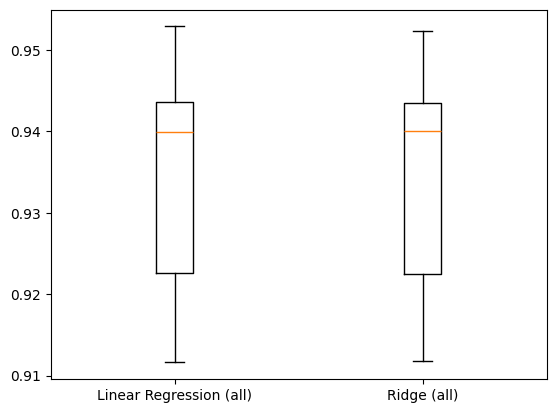

In [66]:
plt.boxplot(
    [model_result for model_result in cross_vals_all_test.values()],
    labels = [model_name for model_name in cross_vals_all_test.keys()]
)
plt.show()

### 4.4 Scaling

Skip straight to scaling this time.

In [67]:
steps_linreg = [('scaler', StandardScaler()),
                  ('lasso', LinearRegression())]
steps_lasso = [('scaler', StandardScaler()),
                  ('lasso', Lasso())]

pipeline_linreg_all_scaled = Pipeline(steps_linreg)
pipeline_lasso_all_scaled = Pipeline(steps_lasso)
pipeline_ridge_all_scaled = Pipeline(steps_ridge)

pipeline_linreg_all_scaled.fit(X_train_all, y_train_all)
pipeline_lasso_all_scaled.fit(X_train_all, y_train_all)
pipeline_ridge_all_scaled.fit(X_train_all, y_train_all)

,steps,"[('scaler', ...), ('ridge', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None


LinReg (scaled) training--testing R²: 0.9498--0.9430
Lasso (scaled) training--testing R²: 0.9498--0.9430
Ridge (scaled) training--testing R²: 0.9498--0.9430


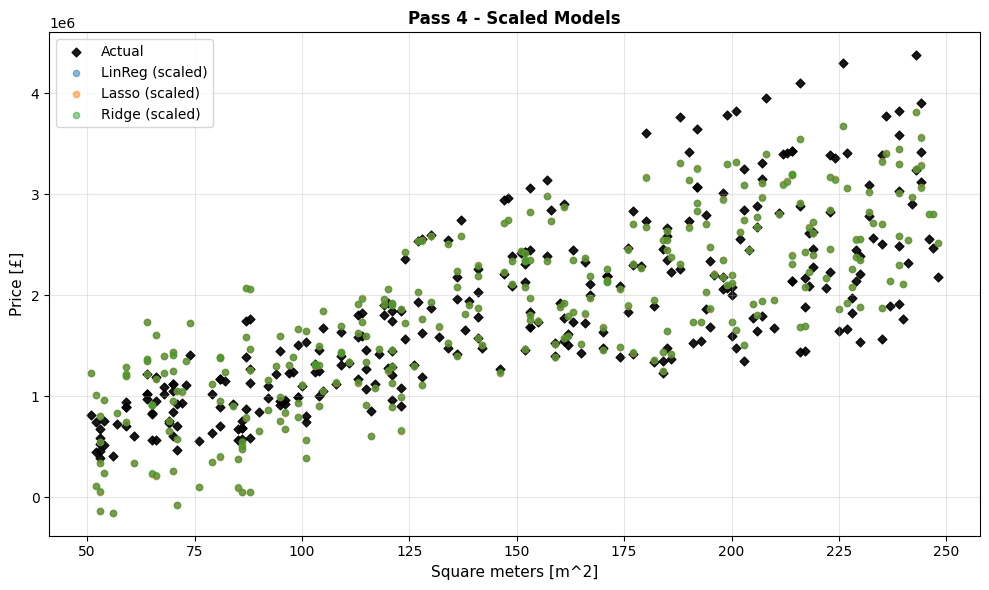

In [68]:
score_predict_plot({'LinReg (scaled)': pipeline_linreg_all_scaled, 
                    'Lasso (scaled)': pipeline_lasso_all_scaled, 
                    'Ridge (scaled)': pipeline_ridge_all_scaled},
                   X_train_all, y_train_all, X_test_all, y_test_all,
                   X_test_sqm, title='Pass 4 - Scaled Models')

### 4.5 Hyperparameter tuning

In [69]:
# Create hyperparameter grids
lasso_all_params = {'lasso__alpha': np.linspace(0.001, 10, 100)}
ridge_all_params = {'ridge__alpha': np.linspace(0.001, 10, 100),
                    'ridge__solver': ['sag', 'lsqr']}
# Instantiate GridSearchCVs
# gridCV_lasso_all = GridSearchCV(pipeline_lasso_all_scaled, lasso_all_params, cv=kf10)
# gridCV_ridge_all = GridSearchCV(pipeline_ridge_all_scaled, ridge_all_params, cv=kf10)
# Instantiate RandomizedSearchCVs
randomCV_lasso_all = RandomizedSearchCV(pipeline_lasso_all_scaled, lasso_all_params, cv=kf10, n_iter=20, random_state=24)
randomCV_ridge_all = RandomizedSearchCV(pipeline_ridge_all_scaled, ridge_all_params, cv=kf10, n_iter=20, random_state=24)
# Save models to dictionary
cvs_all = {
            # 'Lasso GridSearchCV': gridCV_lasso_all,
            # 'Ridge GridSearchCV': gridCV_ridge_all,
            'Lasso RandomizedSearchCV': randomCV_lasso_all,
            'Ridge RandomizedSearchCV': randomCV_ridge_all
            }

Training set scores

In [70]:
cvs_results_all = evaluate_CVs(cvs_all, X_train_all, y_train_all)

----- Lasso RandomizedSearchCV -----
Top score: 0.9427
Top params: {'lasso__alpha': 9.495}
----- Ridge RandomizedSearchCV -----
Top score: 0.9428
Top params: {'ridge__solver': 'sag', 'ridge__alpha': 3.637}


Testing set scores

In [71]:
cvs_results_all_test = evaluate_CVs(cvs_all, X_test_all, y_test_all)

----- Lasso RandomizedSearchCV -----
Top score: 0.9346
Top params: {'lasso__alpha': 9.495}
----- Ridge RandomizedSearchCV -----
Top score: 0.9347
Top params: {'ridge__solver': 'sag', 'ridge__alpha': 2.4250000000000003}


### 4.6 PCA
Before scaling

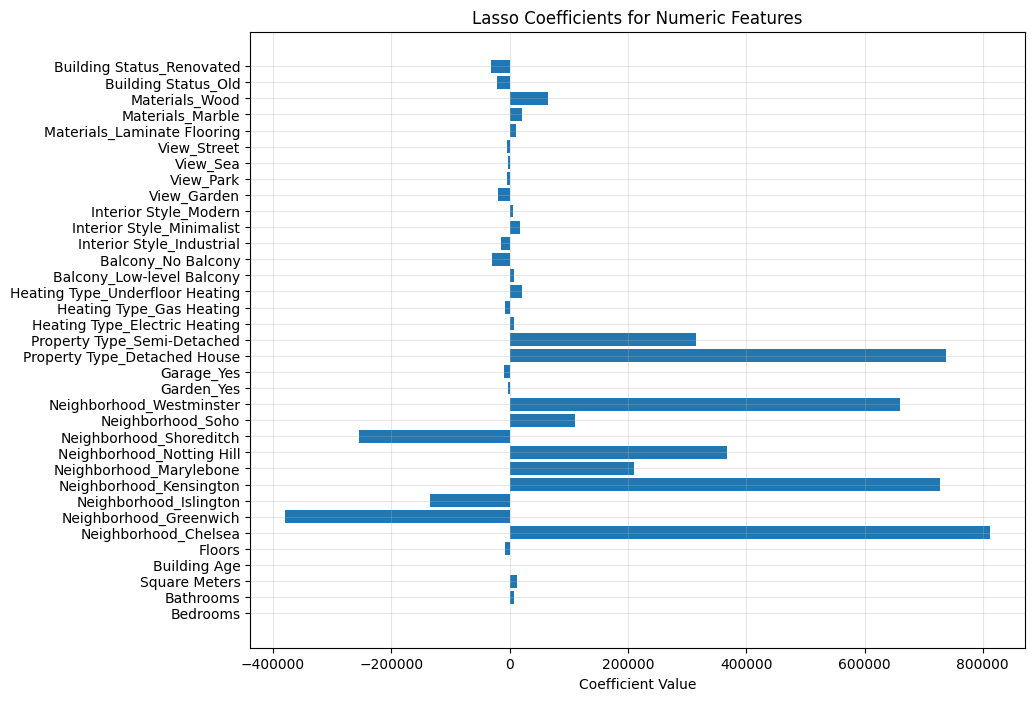

In [72]:
lasso_coeff_all = Lasso(alpha = 0.1).fit(X_train_all, y_train_all).coef_

plt.figure(figsize=(10, 8))
plt.barh(X_train_all.columns, lasso_coeff_all)
plt.xlabel('Coefficient Value')
plt.title('Lasso Coefficients for Numeric Features')
plt.grid(True, alpha=0.3)
plt.show()

After scaling - first, sort columns by those with the largest coefficients

In [73]:
scaled_all = scaler1.fit_transform(X_train_all)
lasso_coeff_all_scaled = Lasso(alpha = 0.1).fit(scaled_all, y_train_all).coef_

lasso_coef_df = pd.DataFrame([X_train_all.columns, lasso_coeff_all_scaled]).transpose()
lasso_coef_df.columns=['Features', 'Coefficients']
lasso_coef_df['Abs. Coeff.'] = np.abs(lasso_coef_df['Coefficients'])
lasso_coef_df.sort_values('Abs. Coeff.', ascending=False).reset_index(drop=True)

,Features,Coefficients,Abs. Coeff.
0,Square Meters,706608.369933,706608.369933
1,Property Type_Detached House,352637.916023,352637.916023
2,Neighborhood_Chelsea,225578.792226,225578.792226
3,Neighborhood_Kensington,223535.164269,223535.164269
4,Neighborhood_Westminster,201952.860251,201952.860251
5,Property Type_Semi-Detached,148587.803579,148587.803579
6,Neighborhood_Greenwich,-111573.427194,111573.427194
7,Neighborhood_Notting Hill,107477.583803,107477.583803
8,Neighborhood_Shoreditch,-71299.250243,71299.250243
9,Neighborhood_Marylebone,70505.763151,70505.763151


Next, plot the coefficients.

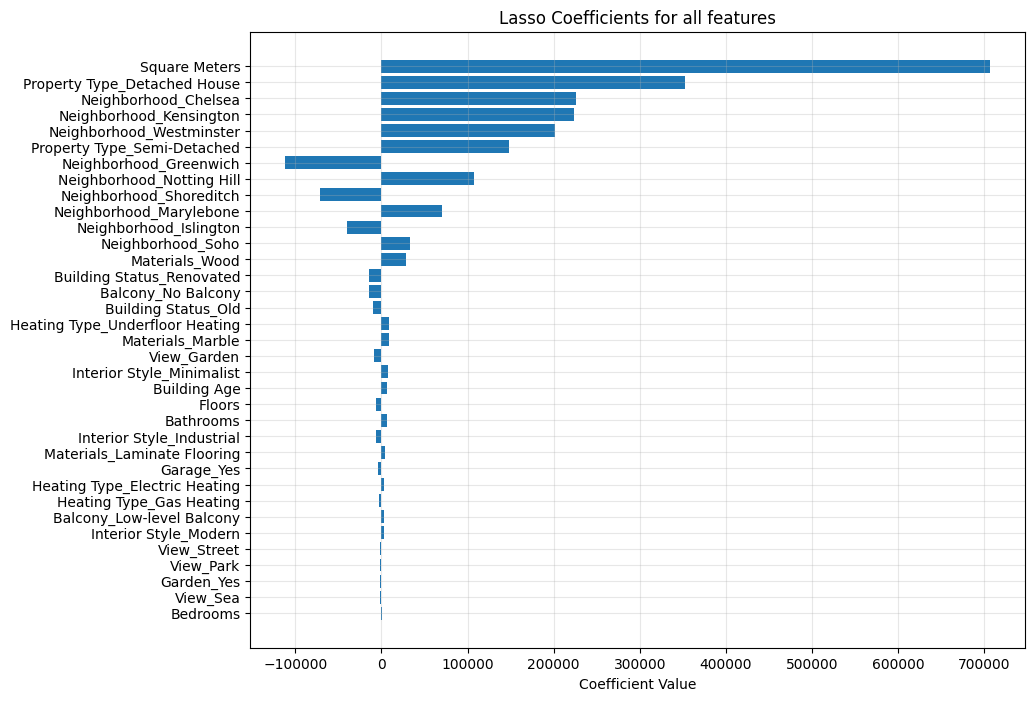

In [74]:
plt.figure(figsize=(10, 8))
plt.barh(lasso_coef_df.sort_values('Abs. Coeff.')['Features'],
         lasso_coef_df.sort_values('Abs. Coeff.')['Coefficients'])
plt.xlabel('Coefficient Value')
plt.title('Lasso Coefficients for all features')
plt.grid(True, alpha=0.3)
plt.show()

### 4.7 Summary
1. Overall:
    1. Lasso model fails to converge on the standard parameters.
    2. Linear, Lasso and Ridge regression all basically still perform the same.
2. Simple models - already a ~10% improvement from using neighborhood data (R^2=0.94).
3. Cross-validation - R^2 range of 0.92-0.96: ~10% improvement on neighborhood data and a tighter range.
4. Scaling - Accuracy is unchanged by scaling but the Lasso model is now able to converge.
5. Hyperparameter Tuning
    - Best performance of R^2=0.94 for GridSearchCV and RandomizedSearchCV
    - The cell doing the hyperparameter tuning now takes ~30s to complete (working on 4 models - Grid & Randomized CVs on Ridge& Lasso)
6. PCA
    - Top coefficient still belongs to 'Square Meters' by a distance
    - The Property Type (Detached vs. Semi-D, vs. Apartment) also rank highly
    - All the neighborhood values are in the top 13, rounded out by 'Materials_Wood'.
    - The number of Bedrooms has the smallest coefficient.

***
## Pass 5 - Top Features
***
Include the top 13 features from the PCA in Pass 4 and see if the models can be run without losing accuracy.

### 5.1 Get Data

In [75]:
top_columns = ['Square Meters',
 'Property Type_Detached House',
 'Neighborhood_Chelsea',
 'Neighborhood_Kensington',
 'Neighborhood_Westminster',
 'Property Type_Semi-Detached',
 'Neighborhood_Greenwich',
 'Neighborhood_Notting Hill',
 'Neighborhood_Shoreditch',
 'Neighborhood_Marylebone',
 'Neighborhood_Islington',
 'Neighborhood_Soho',
 'Materials_Wood']
top_columns_df = all_df[top_columns]
top_columns_df.head()

,Square Meters,Property Type_Detached House,Neighborhood_Chelsea,Neighborhood_Kensington,Neighborhood_Westminster,Property Type_Semi-Detached,Neighborhood_Greenwich,Neighborhood_Notting Hill,Neighborhood_Shoreditch,Neighborhood_Marylebone,Neighborhood_Islington,Neighborhood_Soho,Materials_Wood
0,179,0,0,0,0,1,0,1,0,0,0,0,0
1,123,0,0,0,1,0,0,0,0,0,0,0,0
2,168,0,0,0,0,1,0,0,0,0,0,1,1
3,237,0,0,0,0,0,0,0,0,0,1,0,0
4,127,0,0,0,0,1,0,0,0,1,0,0,1


In [76]:
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(top_columns_df, y, test_size=0.3, random_state=24)

print(X_train_top.shape, X_test_top.shape, y_train_top.shape, y_test_top.shape)

(700, 13) (300, 13) (700,) (300,)


### 5.2 Scaled models

In [77]:
pipeline_linreg_top_scaled = Pipeline(steps_linreg)
pipeline_lasso_top_scaled = Pipeline(steps_lasso)
pipeline_ridge_top_scaled = Pipeline(steps_ridge)

pipeline_linreg_top_scaled.fit(X_train_top, y_train_top)
pipeline_lasso_top_scaled.fit(X_train_top, y_train_top)
pipeline_ridge_top_scaled.fit(X_train_top, y_train_top)

,steps,"[('scaler', ...), ('ridge', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None


In [78]:
models_top = {'LinReg - Top (pipeline, scaled)': pipeline_linreg_top_scaled, 
              'Lasso - Top (pipeline, scaled)': pipeline_lasso_top_scaled, 
              'Ridge - Top (pipeline, scaled)': pipeline_ridge_top_scaled}

LinReg - Top (pipeline, scaled) training--testing R²: 0.9487--0.9445
Lasso - Top (pipeline, scaled) training--testing R²: 0.9487--0.9445
Ridge - Top (pipeline, scaled) training--testing R²: 0.9487--0.9445


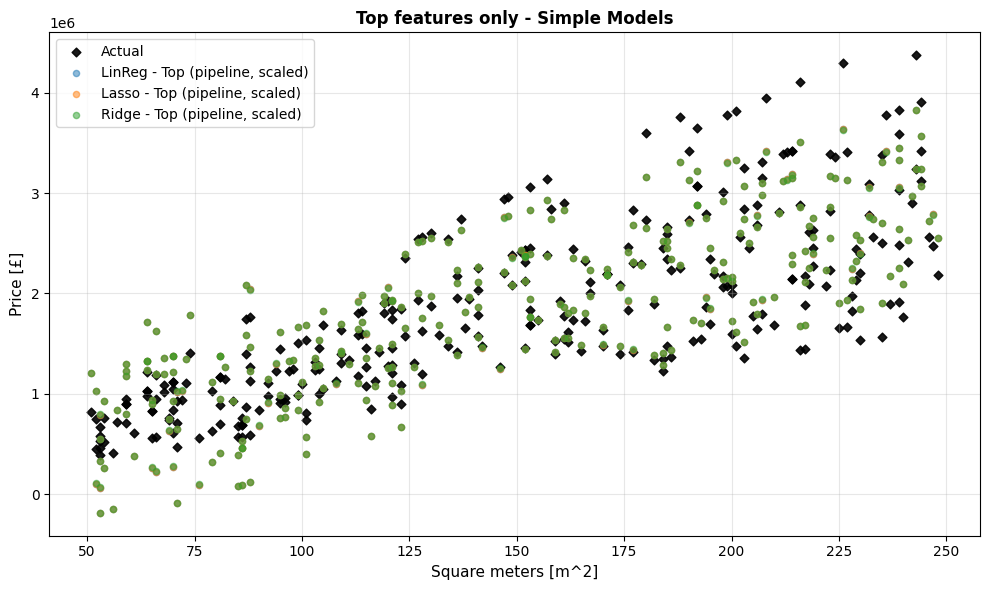

In [79]:
score_predict_plot(models_top,
                   X_train_top, y_train_top, X_test_top, y_test_top,
                   X_test_sqm, title='Top features only - Simple Models')

### 5.3 Cross validation

Training set scores

In [80]:
cross_vals_top_train = multi_cross_val_score(
    models = models_top,
    X = X_train_top,
    y = y_train_top,
    kf = kf10
)

LinReg - Top (pipeline, scaled) cross-validation scores: 0.917 --- 0.946 --- 0.966
Lasso - Top (pipeline, scaled) cross-validation scores: 0.917 --- 0.946 --- 0.966
Ridge - Top (pipeline, scaled) cross-validation scores: 0.917 --- 0.946 --- 0.966


Test set scores

In [81]:
cross_vals_top_test = multi_cross_val_score(
    models = models_top,
    X = X_test_top,
    y = y_test_top,
    kf = kf10
)

LinReg - Top (pipeline, scaled) cross-validation scores: 0.921 --- 0.939 --- 0.958
Lasso - Top (pipeline, scaled) cross-validation scores: 0.921 --- 0.939 --- 0.958
Ridge - Top (pipeline, scaled) cross-validation scores: 0.922 --- 0.939 --- 0.958


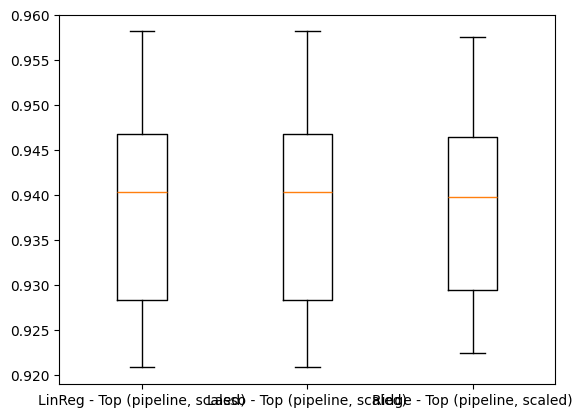

In [82]:
plt.boxplot(
    [model_result for model_result in cross_vals_top_test.values()],
    labels = [model_name for model_name in cross_vals_top_test.keys()]
)
plt.show()

### 5.4 Hyperparameter tuning


In [83]:
# Instantiate GridSearchCVs
gridCV_lasso_top = GridSearchCV(pipeline_lasso_top_scaled, lasso_all_params, cv=kf10)
gridCV_ridge_top = GridSearchCV(pipeline_ridge_top_scaled, ridge_all_params, cv=kf10)
# Instantiate RandomizedSearchCVs
randomCV_lasso_top = RandomizedSearchCV(pipeline_lasso_top_scaled, lasso_all_params, cv=kf10, n_iter=10, random_state=24)
randomCV_ridge_top = RandomizedSearchCV(pipeline_ridge_top_scaled, ridge_all_params, cv=kf10, n_iter=10, random_state=24)
# Save models to dictionary
cvs_top = {'Lasso - Top GridSearchCV': gridCV_lasso_top,
            'Ridge - Top GridSearchCV': gridCV_ridge_top,
            'Lasso - Top RandomizedSearchCV': randomCV_lasso_top,
            'Ridge - Top RandomizedSearchCV': randomCV_ridge_top
            }

Training set scores

In [84]:
cvs_results_top = evaluate_CVs(cvs_top, X_train_top, y_train_top)

----- Lasso - Top GridSearchCV -----
Top score: 0.9460
Top params: {'lasso__alpha': 10.0}
----- Ridge - Top GridSearchCV -----
Top score: 0.9460
Top params: {'ridge__alpha': 2.122, 'ridge__solver': 'sag'}
----- Lasso - Top RandomizedSearchCV -----
Top score: 0.9460
Top params: {'lasso__alpha': 8.889}
----- Ridge - Top RandomizedSearchCV -----
Top score: 0.9460
Top params: {'ridge__solver': 'sag', 'ridge__alpha': 2.4250000000000003}


Test set scores

In [85]:
cvs_results_top_test = evaluate_CVs(cvs_top, X_test_top, y_test_top)

----- Lasso - Top GridSearchCV -----
Top score: 0.9391
Top params: {'lasso__alpha': 10.0}
----- Ridge - Top GridSearchCV -----
Top score: 0.9392
Top params: {'ridge__alpha': 1.819, 'ridge__solver': 'sag'}
----- Lasso - Top RandomizedSearchCV -----
Top score: 0.9391
Top params: {'lasso__alpha': 8.889}
----- Ridge - Top RandomizedSearchCV -----
Top score: 0.9392
Top params: {'ridge__solver': 'sag', 'ridge__alpha': 2.4250000000000003}


Success! These models maintain 94% $R^2$ using only the best features, and the hyperparameter tuning was more than twice as fast.

***
Conclusions
***

1. Square meters remains the strongest predictor
2. However, the neighborhoods are influential too - jump from 60% to 80% R $^2$
3. Adding in the different kinds of view gets you roughly another 10%.
4. Ultimately we can use get 90+% R $^2$ with just 13 or so features.
5. Linear, Lasso and Ridge regression all perform equally on this dataset.
6. Best hyperparameters:
    - Lasso - alpha >= 10
    - Ridge - alpha ≈ 3, solver = 'sag'

In [86]:
# Analyzing the hyperparameter tuning from each pass
hyperparam_results = {'Pass 1': cv_results_sqm,
                      'Pass 2': cv_results_num,
                      'Pass 3': cv_results_neighbor,
                      'Pass 4': cvs_results_all,
                      'Pass 5': cvs_results_top}

def print_hyperparams(results_dict, model_type):
    print('--- {model_type} ---')
    for key1, result in results_dict.items():
        print(key1)
        for key2, params in result.items():
            if model_type in key2:
                print(f'{key2}: {params}')

print_hyperparams(hyperparam_results, 'Lasso')
print_hyperparams(hyperparam_results, 'Ridge')

--- {model_type} ---
Pass 1
Lasso GridSearchCV: [0.6295668661897607, {'alpha': 10.0}]
Lasso RandomizedSearchCV: [0.6295668652544718, {'alpha': 8.163448979591838}]
Pass 2
Lasso GridSearchCV: [0.6267405996993188, {'alpha': 100.0}]
Lasso RandomizedSearchCV: [0.6267405996993188, {'alpha': 100.0}]
Pass 3
Lasso GridSearchCV: [0.8222338800948414, {'alpha': 10.0}]
Lasso RandomizedSearchCV: [0.8222331003632787, {'alpha': 8.163448979591838}]
Pass 4
Lasso RandomizedSearchCV: [0.9427216605314073, {'lasso__alpha': 9.495}]
Pass 5
Lasso - Top GridSearchCV: [0.9460019425606688, {'lasso__alpha': 10.0}]
Lasso - Top RandomizedSearchCV: [0.9460018996692033, {'lasso__alpha': 8.889}]
--- {model_type} ---
Pass 1
Ridge GridSearchCV: [0.630267966554119, {'alpha': 2.0416122448979594, 'solver': 'sag'}]
Ridge RandomizedSearchCV: [0.6295969162174535, {'solver': 'sag', 'alpha': 7.755326530612246}]
Pass 2
Ridge GridSearchCV: [0.6271186203362442, {'alpha': 100.0, 'solver': 'lsqr'}]
Ridge RandomizedSearchCV: [0.627118

## Extra 1 - Using all the worst coefficients
What if we used all the feature _except_ the top 13? Will the model do worse, and if so by how much?

In [87]:
bottom_columns = ['Building Status_Renovated',
 'Balcony_No Balcony',
 'Building Status_Old',
 'Heating Type_Underfloor Heating',
 'Materials_Marble',
 'View_Garden',
 'Interior Style_Minimalist',
 'Building Age',
 'Floors',
 'Bathrooms',
 'Interior Style_Industrial',
 'Materials_Laminate Flooring',
 'Garage_Yes',
 'Heating Type_Electric Heating',
 'Heating Type_Gas Heating',
 'Balcony_Low-level Balcony',
 'Interior Style_Modern',
 'View_Street',
 'View_Park',
 'Garden_Yes',
 'View_Sea',
 'Bedrooms',]
bottom_columns_df = all_df[bottom_columns]
bottom_columns_df.head()

,Building Status_Renovated,Balcony_No Balcony,Building Status_Old,Heating Type_Underfloor Heating,Materials_Marble,View_Garden,Interior Style_Minimalist,Building Age,Floors,Bathrooms,...,Garage_Yes,Heating Type_Electric Heating,Heating Type_Gas Heating,Balcony_Low-level Balcony,Interior Style_Modern,View_Street,View_Park,Garden_Yes,View_Sea,Bedrooms
0,1,0,0,0,1,1,0,72,3,3,...,0,1,0,0,0,0,0,0,0,2
1,0,0,1,0,0,0,0,34,1,1,...,0,0,0,0,0,0,0,1,0,2
2,1,1,0,0,0,0,0,38,3,3,...,1,0,0,0,0,1,0,0,0,5
3,1,1,0,1,0,0,0,53,1,1,...,1,0,0,0,0,0,1,1,0,5
4,0,1,1,0,0,0,0,23,2,1,...,1,0,0,0,1,0,1,0,0,4


In [88]:
X_train_bottom, X_test_bottom, y_train_bottom, y_test_bottom = train_test_split(bottom_columns_df, y, test_size=0.3, random_state=24)

print(X_train_bottom.shape, X_test_bottom.shape, y_train_bottom.shape, y_test_bottom.shape)

(700, 22) (300, 22) (700,) (300,)


In [89]:
pipeline_linreg_bottom_scaled = Pipeline(steps_linreg)
pipeline_lasso_bottom_scaled = Pipeline(steps_lasso)
pipeline_ridge_bottom_scaled = Pipeline(steps_ridge)

pipeline_linreg_bottom_scaled.fit(X_train_bottom, y_train_bottom)
pipeline_lasso_bottom_scaled.fit(X_train_bottom, y_train_bottom)
pipeline_ridge_bottom_scaled.fit(X_train_bottom, y_train_bottom)

,steps,"[('scaler', ...), ('ridge', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None


In [90]:
models_bottom = {'LinReg (scaled)': pipeline_linreg_bottom_scaled, 
                 'Lasso (scaled)': pipeline_lasso_bottom_scaled, 
                 'Ridge (scaled)': pipeline_ridge_bottom_scaled}

LinReg (scaled) training--testing R²: 0.0439---0.0214
Lasso (scaled) training--testing R²: 0.0439---0.0214
Ridge (scaled) training--testing R²: 0.0439---0.0213


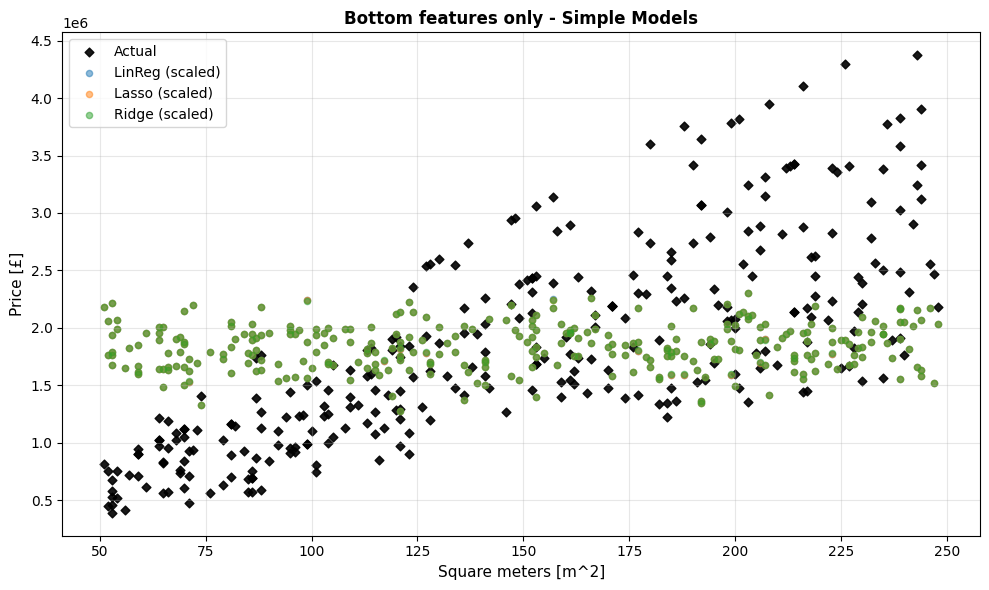

In [91]:
score_predict_plot(models_bottom,
                   X_train_bottom, y_train_bottom, X_test_bottom, y_test_bottom,
                   X_test_sqm, title='Bottom features only - Simple Models')

Woeful!

## Extra 2 - predicting braithwaite house value

In [92]:
# Set Braithwaite house variables
braithwaite_house_16 = {'Address': 'Flat 16 Braithwaite House',
                        'Neighborhood': 'Islington',
                        'Bedrooms': 2,
                        'Bathrooms': 1,
                        'Square Meters': 75,
                        'Building Age': 80,
                        'Garden': 'Yes',
                        'Garage': 'No',
                        'Floors': 2,
                        'Property Type': 'Apartment',
                        'Heating Type': 'Central Heating',
                        'Balcony': 'No Balcony',
                        'Interior Style': 'Modern',
                        'View': 'Park',
                        'Materials': 'Wood',
                        'Building Status': 'Renovated',
                        'Price (£)': 535000}

In [93]:
# Give braithwaite house its own DF
braithwaite_house_16_df = pd.DataFrame.from_records([braithwaite_house_16], index=[1])
# Add Braithwaite house to housing_df
housing_df_plus = pd.concat([housing_df, braithwaite_house_16_df])
housing_df_plus.tail()

,Address,Neighborhood,Bedrooms,Bathrooms,Square Meters,Building Age,Garden,Garage,Floors,Property Type,Heating Type,Balcony,Interior Style,View,Materials,Building Status,Price (£)
996,165 Park Lane,Camden,1,1,65,51,No,No,1,Apartment,Underfloor Heating,No Balcony,Industrial,Garden,Wood,Old,563333
997,99 Camden High Street,Camden,4,1,191,27,No,Yes,2,Semi-Detached,Central Heating,Low-level Balcony,Minimalist,Park,Laminate Flooring,Old,1986399
998,155 Park Lane,Camden,5,2,131,3,Yes,No,2,Detached House,Underfloor Heating,High-level Balcony,Modern,Park,Laminate Flooring,Renovated,1703000
999,145 Baker Street,Kensington,4,2,185,53,No,No,1,Apartment,Electric Heating,No Balcony,Modern,Street,Wood,Old,2343333
1,Flat 16 Braithwaite House,Islington,2,1,75,80,Yes,No,2,Apartment,Central Heating,No Balcony,Modern,Park,Wood,Renovated,535000


In [94]:
# Convert new housing_df categoric data to integers
housing_df_plus_dummies = pd.get_dummies(housing_df_plus[categoric_columns], drop_first=True).astype('int')
# Combine new housing_df categoric dat and with numeric data
housing_df_plus_all = pd.concat([housing_df_plus[numeric_columns], housing_df_plus_dummies], axis=1)
housing_df_plus_all.tail()

,Bedrooms,Bathrooms,Square Meters,Building Age,Floors,Neighborhood_Chelsea,Neighborhood_Greenwich,Neighborhood_Islington,Neighborhood_Kensington,Neighborhood_Marylebone,...,Interior Style_Modern,View_Garden,View_Park,View_Sea,View_Street,Materials_Laminate Flooring,Materials_Marble,Materials_Wood,Building Status_Old,Building Status_Renovated
996,1,1,65,51,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0
997,4,1,191,27,2,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
998,5,2,131,3,2,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,1
999,4,2,185,53,1,0,0,0,1,0,...,1,0,0,0,1,0,0,1,1,0
1,2,1,75,80,2,0,0,1,0,0,...,1,0,1,0,0,0,0,1,0,1


In [95]:
# Make predictions for Braithwaite house
print(linreg_all.predict(housing_df_plus_all.iloc[-2:]))
# print(lasso_all.predict(housing_df_plus_all.iloc[-2:]))
print(ridge_all.predict(housing_df_plus_all.iloc[-2:]))

[2451385.02358069  220736.12144366]
[2450929.37257032  221566.01598792]


***
## Extra 3 - Comprehensive model evaluation
***

### E3.1 - Evaluation function
Define `evaluate_regression_model()` which performs an 11-step evaluation of a model:
1. 

In [96]:
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_validate
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [97]:
def evaluate_regression_model(reg_model, model_name,
                              X_train, y_train, X_test, y_test, 
                              cv_folds=5,
                              show_plots=True, save_plots=True, verbose=True):
    """
    Comprehensive evaluation of a fitted regression model.
    
    Parameters:
    -----------
    reg_model : sklearn estimator
        Fitted regression model (LinearRegression, Lasso, or Ridge)
    X_train : array-like
        Training features
    y_train : array-like
        Training target values
    X_test : array-like
        Test features
    y_test : array-like
        Test target values
    cv_folds : int, default=5
        Number of cross-validation folds
    save_plots : bool, default=True
        Whether to save diagnostic plots
    verbose : bool, default=True
        Whether to print detailed output during evaluation
        
    Returns:
    --------
    dict : Dictionary containing all evaluation metrics
    """
    
    if verbose:
        print("="*80)
        print("COMPREHENSIVE REGRESSION MODEL EVALUATION")
        print("="*80)
        print(f"\nModel Type: {type(reg_model).__name__}")
        print(f"Training Set Size: {X_train.shape[0]} samples, {X_train.shape[1]} features")
        print(f"Test Set Size: {X_test.shape[0]} samples")
    
    # Generate predictions
    y_train_pred = reg_model.predict(X_train)
    y_test_pred = reg_model.predict(X_test)
    
    # Initialize results dictionary
    results = {'Model Name': model_name}
    
    # ========================================================================
    # 1. R² SCORE (COEFFICIENT OF DETERMINATION)
    # ========================================================================
    if verbose:
        print("\n" + "="*80)
        print("1. R² SCORE (Coefficient of Determination)")
        print("="*80)
    
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    results['train_r2'] = train_r2
    results['test_r2'] = test_r2
    
    if verbose:
        print(f"\nTraining R²:   {train_r2:.4f}")
        print(f"Test R²:       {test_r2:.4f}")
        print(f"Difference:    {train_r2 - test_r2:.4f}")
        
        if test_r2 < 0:
            print("⚠ WARNING: Negative R² indicates model performs worse than baseline!")
        elif test_r2 < 0.5:
            print("⚠ Model explains less than 50% of variance - consider feature engineering")
        elif test_r2 > 0.8:
            print("✓ Strong model - explains >80% of variance")
        
        if (train_r2 - test_r2) > 0.1:
            print("⚠ Large gap suggests overfitting")
    
    # ========================================================================
    # 2. ADJUSTED R²
    # ========================================================================
    if verbose:
        print("\n" + "="*80)
        print("2. ADJUSTED R²")
        print("="*80)
    
    n_train = X_train.shape[0]
    n_test = X_test.shape[0]
    p = X_train.shape[1]
    
    train_adj_r2 = 1 - (1 - train_r2) * (n_train - 1) / (n_train - p - 1)
    test_adj_r2 = 1 - (1 - test_r2) * (n_test - 1) / (n_test - p - 1)
    
    results['train_adj_r2'] = train_adj_r2
    results['test_adj_r2'] = test_adj_r2
    
    if verbose:
        print(f"\nTraining Adjusted R²:  {train_adj_r2:.4f}")
        print(f"Test Adjusted R²:      {test_adj_r2:.4f}")
        print(f"\nAdjusted R² penalizes for {p} features")
    
    # ========================================================================
    # 3. RMSE (ROOT MEAN SQUARED ERROR)
    # ========================================================================
    if verbose:
        print("\n" + "="*80)
        print("3. RMSE (Root Mean Squared Error)")
        print("="*80)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    results['train_rmse'] = train_rmse
    results['test_rmse'] = test_rmse
    
    # Calculate as percentage of mean price
    train_rmse_pct = (train_rmse / np.mean(y_train)) * 100
    test_rmse_pct = (test_rmse / np.mean(y_test)) * 100
    
    if verbose:
        print(f"\nTraining RMSE: £{train_rmse:,.2f}")
        print(f"Test RMSE:     £{test_rmse:,.2f}")
        print(f"\nAs percentage of mean price:")
        print(f"Training:      {train_rmse_pct:.2f}%")
        print(f"Test:          {test_rmse_pct:.2f}%")
        
        if test_rmse / train_rmse > 1.5:
            print("⚠ Test RMSE is >1.5x training RMSE - significant overfitting")
    
    # ========================================================================
    # 4. MAE (MEAN ABSOLUTE ERROR)
    # ========================================================================
    if verbose:
        print("\n" + "="*80)
        print("4. MAE (Mean Absolute Error)")
        print("="*80)
    
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    results['train_mae'] = train_mae
    results['test_mae'] = test_mae
    
    train_mae_pct = (train_mae / np.mean(y_train)) * 100
    test_mae_pct = (test_mae / np.mean(y_test)) * 100
    
    if verbose:
        print(f"\nTraining MAE:  £{train_mae:,.2f}")
        print(f"Test MAE:      £{test_mae:,.2f}")
        print(f"\nAs percentage of mean price:")
        print(f"Training:      {train_mae_pct:.2f}%")
        print(f"Test:          {test_mae_pct:.2f}%")
        
        print(f"\nInterpretation: Typical prediction error is £{test_mae:,.2f}")
    
    # ========================================================================
    # 5. MAPE (MEAN ABSOLUTE PERCENTAGE ERROR)
    # ========================================================================
    if verbose:
        print("\n" + "="*80)
        print("5. MAPE (Mean Absolute Percentage Error)")
        print("="*80)
    
    # Avoid division by zero
    train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
    test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
    
    results['train_mape'] = train_mape
    results['test_mape'] = test_mape
    
    if verbose:
        print(f"\nTraining MAPE: {train_mape:.2f}%")
        print(f"Test MAPE:     {test_mape:.2f}%")
        print("\n⚠ Note: MAPE can be biased toward lower-priced properties")
    
    # ========================================================================
    # 6. CROSS-VALIDATION SCORES
    # ========================================================================
    if verbose:
        print("\n" + "="*80)
        print(f"6. CROSS-VALIDATION ({cv_folds}-Fold)")
        print("="*80)
        
        print(f"\nPerforming {cv_folds}-fold cross-validation on training data...")
    
    # Perform cross-validation with multiple metrics
    cv_results = cross_validate(
        reg_model, X_train, y_train, 
        cv=cv_folds,
        scoring={
            'r2': 'r2',
            'neg_rmse': 'neg_root_mean_squared_error',
            'neg_mae': 'neg_mean_absolute_error'
        },
        return_train_score=True
    )
    
    cv_r2_mean = cv_results['test_r2'].mean()
    cv_r2_std = cv_results['test_r2'].std()
    cv_rmse_mean = -cv_results['test_neg_rmse'].mean()
    cv_rmse_std = cv_results['test_neg_rmse'].std()
    cv_mae_mean = -cv_results['test_neg_mae'].mean()
    cv_mae_std = cv_results['test_neg_mae'].std()
    
    results['cv_r2_mean'] = cv_r2_mean
    results['cv_r2_std'] = cv_r2_std
    results['cv_rmse_mean'] = cv_rmse_mean
    results['cv_rmse_std'] = cv_rmse_std
    results['cv_mae_mean'] = cv_mae_mean
    results['cv_mae_std'] = cv_mae_std
    
    if verbose:
        print(f"\nCross-Validated R²:    {cv_r2_mean:.4f} (±{cv_r2_std:.4f})")
        print(f"Cross-Validated RMSE:  £{cv_rmse_mean:,.2f} (±£{cv_rmse_std:,.2f})")
        print(f"Cross-Validated MAE:   £{cv_mae_mean:,.2f} (±£{cv_mae_std:,.2f})")
        
        if cv_r2_std > 0.1:
            print("⚠ High standard deviation - model performance varies significantly across folds")
        else:
            print("✓ Low standard deviation - model performance is stable")
    
    # ========================================================================
    # 7. RESIDUAL ANALYSIS (plots after Final Summary)
    # ========================================================================
    if verbose:
        print("\n" + "="*80)
        print("7. RESIDUAL ANALYSIS")
        print("="*80)
    
    train_residuals = y_train - y_train_pred
    test_residuals = y_test - y_test_pred
    
    if verbose:
        print("\nTraining Residuals:")
        print(f"  Mean:     £{np.mean(train_residuals):,.2f} (should be ~0)")
        print(f"  Std Dev:  £{np.std(train_residuals):,.2f}")
        print(f"  Min:      £{np.min(train_residuals):,.2f}")
        print(f"  Max:      £{np.max(train_residuals):,.2f}")
        
        print("\nTest Residuals:")
        print(f"  Mean:     £{np.mean(test_residuals):,.2f} (should be ~0)")
        print(f"  Std Dev:  £{np.std(test_residuals):,.2f}")
        print(f"  Min:      £{np.min(test_residuals):,.2f}")
        print(f"  Max:      £{np.max(test_residuals):,.2f}")
    
    # Test for normality (Shapiro-Wilk test on sample if large dataset)
    if len(test_residuals) > 5000:
        sample_residuals = np.random.choice(test_residuals, 5000, replace=False)
    else:
        sample_residuals = test_residuals
    
    _, p_value = stats.shapiro(sample_residuals)
    
    if verbose:
        print(f"\nShapiro-Wilk Normality Test (p-value): {p_value:.4f}")
        if p_value < 0.05:
            print("⚠ Residuals are NOT normally distributed (p < 0.05)")
        else:
            print("✓ Residuals appear normally distributed (p >= 0.05)")
    
    # ========================================================================
    # 8. TRAIN VS TEST PERFORMANCE COMPARISON
    # ========================================================================
    if verbose:
        print("\n" + "="*80)
        print("8. TRAIN VS TEST PERFORMANCE COMPARISON")
        print("="*80)
        
        print("\n{:<20} {:<15} {:<15} {:<15}".format("Metric", "Training", "Test", "Ratio (Test/Train)"))
        print("-" * 65)
        print("{:<20} {:<15.4f} {:<15.4f} {:<15.2f}".format(
            "R²", train_r2, test_r2, test_r2/train_r2 if train_r2 != 0 else 0))
        print("{:<20} £{:<14,.0f} £{:<14,.0f} {:<15.2f}".format(
            "RMSE", train_rmse, test_rmse, test_rmse/train_rmse))
        print("{:<20} £{:<14,.0f} £{:<14,.0f} {:<15.2f}".format(
            "MAE", train_mae, test_mae, test_mae/train_mae))
    
    # Overfitting assessment
    rmse_ratio = test_rmse / train_rmse
    if verbose:
        if rmse_ratio > 1.5:
            print("\n⚠ SEVERE OVERFITTING: Test RMSE is >1.5x training RMSE")
            print("   Recommendations: Regularization, feature reduction, more data")
        elif rmse_ratio > 1.2:
            print("\n⚠ MODERATE OVERFITTING: Test RMSE is >1.2x training RMSE")
            print("   Recommendations: Consider regularization or cross-validation")
        else:
            print("\n✓ GOOD GENERALIZATION: Test performance close to training")
    
    # ========================================================================
    # 9. BUSINESS/DOMAIN METRICS
    # ========================================================================
    if verbose:
        print("\n" + "="*80)
        print("9. BUSINESS/DOMAIN METRICS")
        print("="*80)
    
    # Predictions within ±10%
    within_10pct = np.abs((y_test - y_test_pred) / y_test) <= 0.10
    pct_within_10 = np.mean(within_10pct) * 100
    
    # Predictions within ±20%
    within_20pct = np.abs((y_test - y_test_pred) / y_test) <= 0.20
    pct_within_20 = np.mean(within_20pct) * 100
    
    # Predictions within ±£50k
    within_50k = np.abs(y_test - y_test_pred) <= 50000
    pct_within_50k = np.mean(within_50k) * 100
    
    results['pct_within_10pct'] = pct_within_10
    results['pct_within_20pct'] = pct_within_20
    results['pct_within_50k'] = pct_within_50k
    
    if verbose:
        print(f"\nPredictions within ±10%:    {pct_within_10:.1f}%")
        print(f"Predictions within ±20%:    {pct_within_20:.1f}%")
        print(f"Predictions within ±£50k:   {pct_within_50k:.1f}%")
    
    # Underpricing vs Overpricing
    underpriced = np.sum(y_test_pred < y_test)
    overpriced = np.sum(y_test_pred > y_test)
    
    if verbose:
        print(f"\nUnderpriced (predicted < actual): {underpriced} ({underpriced/len(y_test)*100:.1f}%)")
        print(f"Overpriced (predicted > actual):  {overpriced} ({overpriced/len(y_test)*100:.1f}%)")
        
        # Error by price segment
        print("\n--- Error Analysis by Price Segment ---")
    
    price_segments = [
        (0, 1000000, "Mid-range (<£1m)"),
        (1000000, 2000000, "Premium (£1m-£2m)"),
        (2000000, 3000000, "Luxury (£2m-£3m)"),
        (3000000, float('inf'), "Ultra Luxury (>£3m)")
    ]
    
    if verbose:
        print("\n{:<25} {:<10} {:<15} {:<15}".format("Segment", "Count", "MAE", "MAPE"))
        print("-" * 65)
    
    for low, high, label in price_segments:
        mask = (y_test >= low) & (y_test < high)
        if np.sum(mask) > 0:
            segment_mae = mean_absolute_error(y_test[mask], y_test_pred[mask])
            segment_mape = np.mean(np.abs((y_test[mask] - y_test_pred[mask]) / y_test[mask])) * 100
            if verbose:
                print("{:<25} {:<10} £{:<14,.0f} {:<15.2f}%".format(
                    label, np.sum(mask), segment_mae, segment_mape))
    
    # ========================================================================
    # 10. PREDICTION INTERVALS (95% Confidence)
    # ========================================================================
    if verbose:
        print("\n" + "="*80)
        print("10. PREDICTION INTERVALS")
        print("="*80)
    
    # Calculate prediction standard error
    residual_std = np.std(test_residuals)
    
    # 95% prediction interval (±1.96 * std)
    lower_bound = y_test_pred - 1.96 * residual_std
    upper_bound = y_test_pred + 1.96 * residual_std
    
    # Check coverage
    coverage = np.mean((y_test >= lower_bound) & (y_test <= upper_bound)) * 100
    
    if verbose:
        print(f"\n95% Prediction Interval Width: ±£{1.96 * residual_std:,.0f}")
        print(f"Actual Coverage: {coverage:.1f}% (should be ~95%)")
        
        if coverage < 90:
            print("⚠ Coverage below 90% - intervals may be too narrow")
        elif coverage > 98:
            print("⚠ Coverage above 98% - intervals may be too wide")
        else:
            print("✓ Good coverage - intervals appropriately calibrated")
        
        # Example predictions with intervals
        print("\n--- Example Predictions with 95% Intervals ---")
        sample_indices = np.random.choice(len(y_test), min(5, len(y_test)), replace=False)
        
        for idx in sample_indices:
            actual = y_test.iloc[idx] if isinstance(y_test, pd.Series) else y_test[idx]
            predicted = y_test_pred[idx]
            lower = lower_bound[idx]
            upper = upper_bound[idx]
            error = actual - predicted
            
            print(f"\nActual: £{actual:,.0f} | Predicted: £{predicted:,.0f} | Error: £{error:,.0f}")
            print(f"95% Interval: [£{lower:,.0f}, £{upper:,.0f}]")
    
    # ========================================================================
    # 11. FEATURE IMPORTANCE (if available)
    # ========================================================================
    if verbose:
        print("\n" + "="*80)
        print("11. FEATURE IMPORTANCE")
        print("="*80)
    
    if hasattr(reg_model, 'coef_'):
        coefficients = reg_model.coef_
        
        # Get feature names if available
        if hasattr(X_train, 'columns'):
            feature_names = X_train.columns
        else:
            feature_names = [f'Feature_{i}' for i in range(X_train.shape[1])]
        
        # Create dataframe of coefficients
        coef_df = pd.DataFrame({
            'Feature': feature_names,
            'Coefficient': coefficients,
            'Abs_Coefficient': np.abs(coefficients)
        }).sort_values('Abs_Coefficient', ascending=False)
        
        if verbose:
            print("\nTop 10 Most Important Features (by absolute coefficient):")
            print(coef_df.head(10).to_string(index=False))
        
        if show_plots:
            #  Plot top 10 features
            plt.figure(figsize=(10, 6))
            top_features = coef_df.head(10)
            colors = ['green' if x > 0 else 'red' for x in top_features['Coefficient']]
            plt.barh(top_features['Feature'], top_features['Coefficient'], color=colors, alpha=0.7)
            plt.xlabel('Coefficient Value')
            plt.title('Top 10 Feature Coefficients (Green=Positive, Red=Negative)')
            plt.tight_layout()
            if save_plots:
                plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
                if verbose:
                    print("\n✓ Feature importance plot saved as 'feature_importance.png'")
            plt.show()
    else:
        if verbose:
            print("\nFeature coefficients not available for this model type")
    
    # ========================================================================
    # FINAL SUMMARY
    # ========================================================================
    if verbose:
        print("\n" + "="*80)
        print("EVALUATION SUMMARY")
        print("="*80)
        
        print(f"\n{'='*80}")
        print("KEY METRICS (Test Set)")
        print(f"{'='*80}")
        print(f"R² Score:                  {test_r2:.4f}")
        print(f"RMSE:                      £{test_rmse:,.0f}")
        print(f"MAE:                       £{test_mae:,.0f}")
        print(f"Within ±10%:               {pct_within_10:.1f}%")
        print(f"Cross-Validated RMSE:      £{cv_rmse_mean:,.0f} (±£{cv_rmse_std:,.0f})")
        
        print(f"\n{'='*80}")
        print("MODEL ASSESSMENT")
        print(f"{'='*80}")
        
        # Overall assessment
        if test_r2 > 0.8 and test_rmse / train_rmse < 1.2:
            print("✓ EXCELLENT: Strong predictive power with good generalization")
        elif test_r2 > 0.6 and test_rmse / train_rmse < 1.3:
            print("✓ GOOD: Decent predictive power, acceptable generalization")
        elif test_r2 > 0.4:
            print("⚠ FAIR: Moderate predictive power, consider improvements")
        else:
            print("✗ POOR: Weak predictive power, significant improvements needed")
        
        print("\n" + "="*80)
        print("EVALUATION COMPLETE")
        print("="*80)

        # Create comprehensive residual plots
    if show_plots:
        fig = plt.figure(figsize=(16, 12))
        
        # 1. Residuals vs Predicted (Test Set)
        ax1 = plt.subplot(2, 3, 1)
        ax1.scatter(y_test_pred, test_residuals, alpha=0.5, s=20)
        ax1.axhline(y=0, color='r', linestyle='--', linewidth=2)
        ax1.set_xlabel('Predicted Price (£)')
        ax1.set_ylabel('Residuals (£)')
        ax1.set_title('Residuals vs Predicted (Test Set)')
        ax1.grid(True, alpha=0.3)
        
        # 2. Residuals vs Actual (Test Set)
        ax2 = plt.subplot(2, 3, 2)
        ax2.scatter(y_test, test_residuals, alpha=0.5, s=20)
        ax2.axhline(y=0, color='r', linestyle='--', linewidth=2)
        ax2.set_xlabel('Actual Price (£)')
        ax2.set_ylabel('Residuals (£)')
        ax2.set_title('Residuals vs Actual (Test Set)')
        ax2.grid(True, alpha=0.3)
        
        # 3. Histogram of Residuals
        ax3 = plt.subplot(2, 3, 3)
        ax3.hist(test_residuals, bins=50, edgecolor='black', alpha=0.7)
        ax3.axvline(x=0, color='r', linestyle='--', linewidth=2)
        ax3.set_xlabel('Residuals (£)')
        ax3.set_ylabel('Frequency')
        ax3.set_title('Distribution of Residuals (Test Set)')
        ax3.grid(True, alpha=0.3)
        
        # 4. Q-Q Plot
        ax4 = plt.subplot(2, 3, 4)
        stats.probplot(test_residuals, dist="norm", plot=ax4)
        ax4.set_title('Q-Q Plot (Normality Check)')
        ax4.grid(True, alpha=0.3)
        
        # 5. Scale-Location Plot (Sqrt of standardized residuals)
        ax5 = plt.subplot(2, 3, 5)
        standardized_residuals = test_residuals / np.std(test_residuals)
        ax5.scatter(y_test_pred, np.sqrt(np.abs(standardized_residuals)), alpha=0.5, s=20)
        ax5.set_xlabel('Predicted Price (£)')
        ax5.set_ylabel('√|Standardized Residuals|')
        ax5.set_title('Scale-Location Plot (Homoscedasticity Check)')
        ax5.grid(True, alpha=0.3)
        
        # 6. Predicted vs Actual
        ax6 = plt.subplot(2, 3, 6)
        ax6.scatter(y_test, y_test_pred, alpha=0.5, s=20)
        min_val = min(y_test.min(), y_test_pred.min())
        max_val = max(y_test.max(), y_test_pred.max())
        ax6.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
        ax6.set_xlabel('Actual Price (£)')
        ax6.set_ylabel('Predicted Price (£)')
        ax6.set_title('Predicted vs Actual (Test Set)')
        ax6.legend()
        ax6.grid(True, alpha=0.3)
        
        plt.tight_layout()
        if save_plots:
            plt.savefig('residual_analysis.png', dpi=300, bbox_inches='tight')
            if verbose:
                print("\n✓ Residual plots saved as 'residual_analysis.png'")
        plt.show()
    
    return results

### E3.2 Evaluating my models

### E3.2.1 - SQM Models

In [98]:
results = evaluate_regression_model(linreg_sqm, 'linreg_sqm', X_train_sqm, y_train_sqm, X_test_sqm, y_test_sqm, show_plots=False, save_plots=False, verbose=False)

### E3.2.3 - Neighborhood + Numeric Features

COMPREHENSIVE REGRESSION MODEL EVALUATION

Model Type: Lasso
Training Set Size: 700 samples, 14 features
Test Set Size: 300 samples

1. R² SCORE (Coefficient of Determination)

Training R²:   0.8325
Test R²:       0.8249
Difference:    0.0076
✓ Strong model - explains >80% of variance

2. ADJUSTED R²

Training Adjusted R²:  0.8291
Test Adjusted R²:      0.8163

Adjusted R² penalizes for 14 features

3. RMSE (Root Mean Squared Error)

Training RMSE: £361,258.11
Test RMSE:     £364,134.73

As percentage of mean price:
Training:      19.60%
Test:          19.85%

4. MAE (Mean Absolute Error)

Training MAE:  £291,196.73
Test MAE:      £300,984.48

As percentage of mean price:
Training:      15.80%
Test:          16.41%

Interpretation: Typical prediction error is £300,984.48

5. MAPE (Mean Absolute Percentage Error)

Training MAPE: 17.84%
Test MAPE:     18.83%

⚠ Note: MAPE can be biased toward lower-priced properties

6. CROSS-VALIDATION (5-Fold)

Performing 5-fold cross-validation on tra

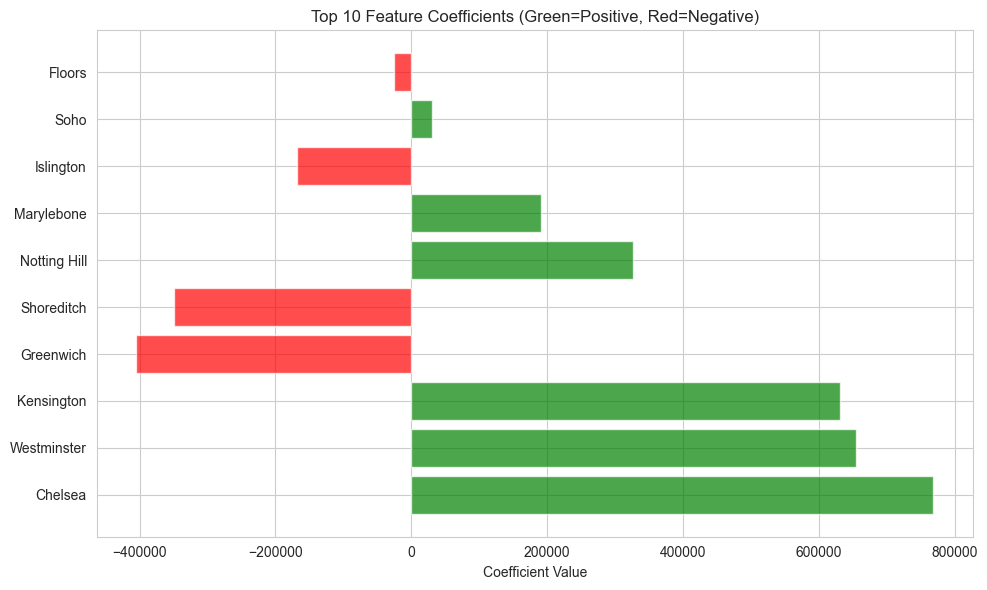


EVALUATION SUMMARY

KEY METRICS (Test Set)
R² Score:                  0.8249
RMSE:                      £364,135
MAE:                       £300,984
Within ±10%:               30.0%
Cross-Validated RMSE:      £371,281 (±£25,077)

MODEL ASSESSMENT
✓ EXCELLENT: Strong predictive power with good generalization

EVALUATION COMPLETE


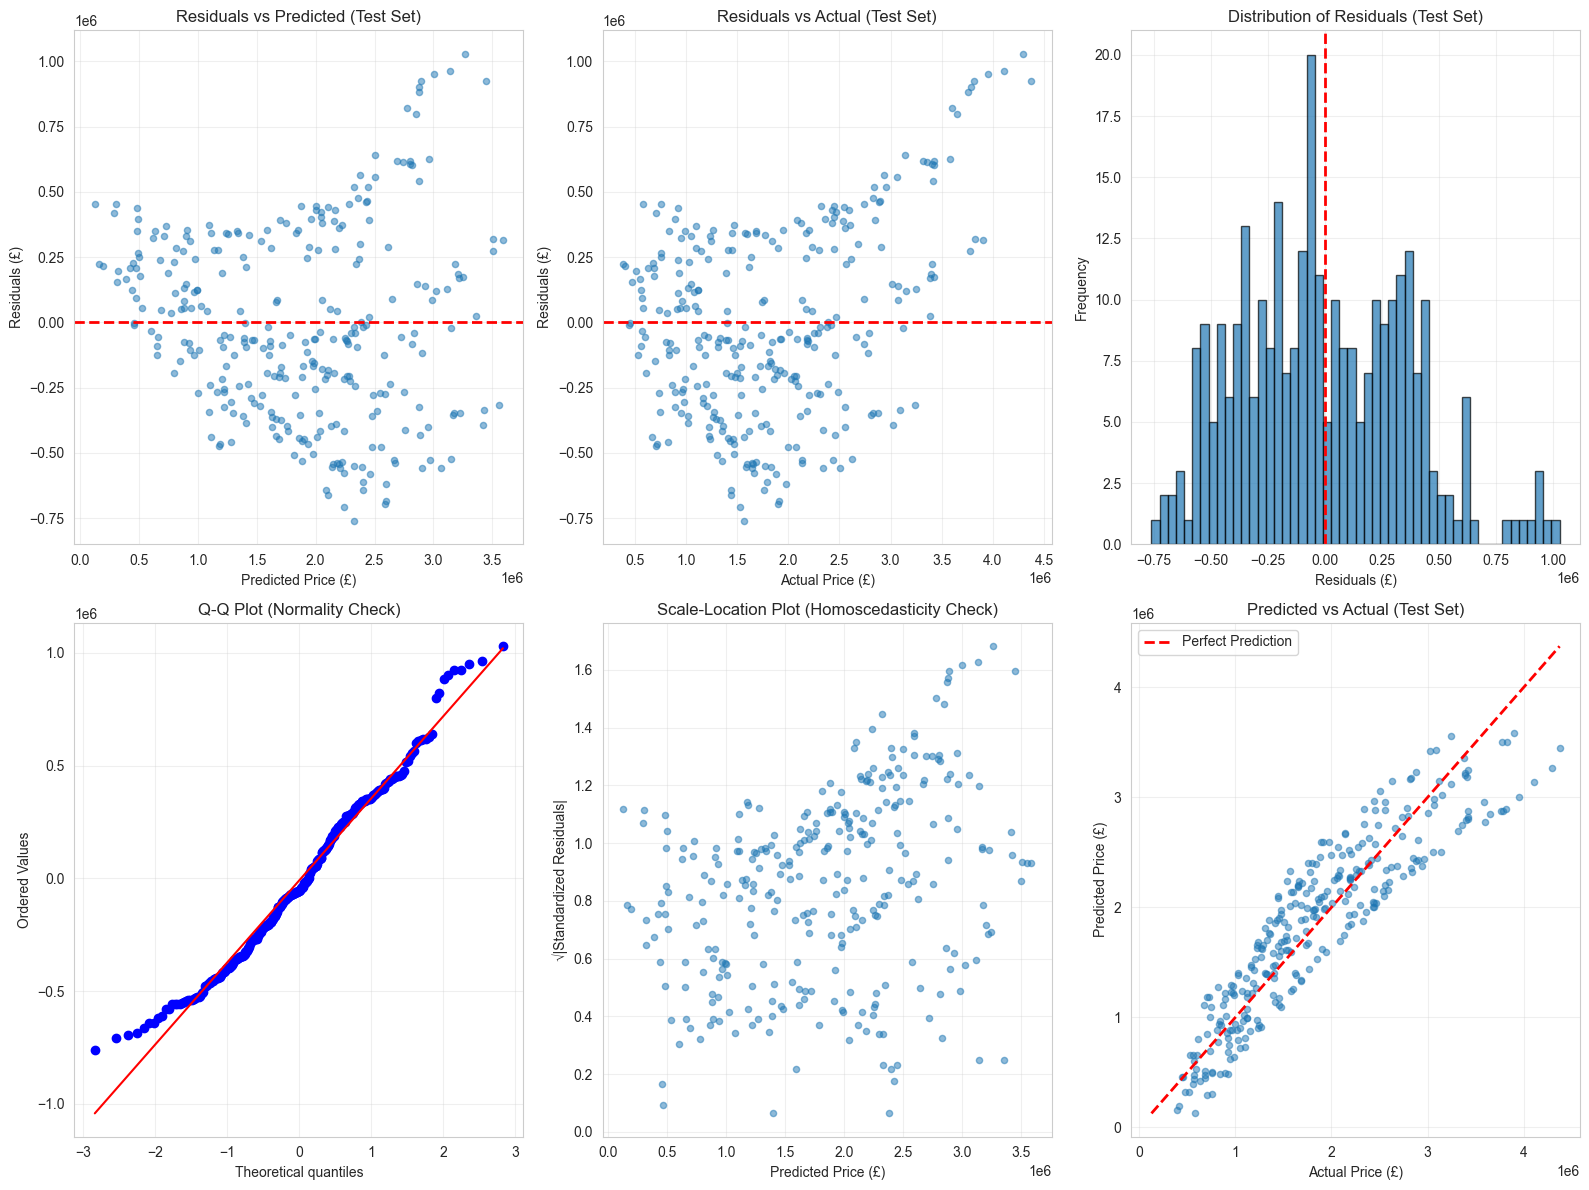

In [99]:
results = evaluate_regression_model(lasso_neighbor, 'lasso_neighbor', X_train_neighbor, y_train_neighbor, X_test_neighbor, y_test_neighbor, save_plots=False)

In [101]:
# Looping over multiple models
def eval_model_dict(model_dict,
                    X_train, y_train, X_test, y_test, 
                    cv_folds=10, show_plots=False, save_plots=False, verbose=True):
    results_list = []
    for model_name, model in model_dict.items():
        results_list.append(
            evaluate_regression_model(model, model_name,
                                      X_train, y_train, X_test, y_test, 
                                      cv_folds, show_plots, save_plots, verbose)
        )
    return pd.DataFrame(results_list)

In [102]:
sqm_evaluation = eval_model_dict(models_sqm,
                                 X_train_sqm, y_train_sqm, X_test_sqm, y_test_sqm,
                                 show_plots=False, save_plots=False, verbose=False)

numeric_evaluation = eval_model_dict(models_numeric,
                                 X_train_numeric, y_train_numeric, X_test_numeric, y_test_numeric,
                                 show_plots=False, save_plots=False, verbose=False)

neighbor_evaluation = eval_model_dict(models_neighbor,
                                 X_train_neighbor, y_train_neighbor, X_test_neighbor, y_test_neighbor,
                                 show_plots=False, save_plots=False, verbose=False)

all_evaluation = eval_model_dict(models_all,
                                 X_train_all, y_train_all, X_test_all, y_test_all,
                                 show_plots=False, save_plots=False, verbose=False)

In [103]:
passes_combined = pd.concat([sqm_evaluation,
                             numeric_evaluation,
                             neighbor_evaluation,
                             all_evaluation], ignore_index=True)
# Round each column to 2 decimal places
passes_combined = passes_combined.round(2)
passes_combined

,Model Name,train_r2,test_r2,train_adj_r2,test_adj_r2,train_rmse,test_rmse,train_mae,test_mae,train_mape,test_mape,cv_r2_mean,cv_r2_std,cv_rmse_mean,cv_rmse_std,cv_mae_mean,cv_mae_std,pct_within_10pct,pct_within_20pct,pct_within_50k
0,Linear Regression (sqm),0.64,0.59,0.64,0.59,530272.30,556327.90,405622.16,431858.67,23.93,25.48,0.62,0.06,531192.91,42117.15,407287.92,21051.75,20.33,49.00,10.67
1,Lasso (sqm),0.64,0.59,0.64,0.59,530272.30,556327.90,405622.16,431858.67,23.93,25.48,0.62,0.06,531192.91,42117.15,407287.92,21051.75,20.33,49.00,10.67
2,Ridge (sqm),0.64,0.59,0.64,0.59,530272.30,556327.90,405622.16,431858.66,23.93,25.48,0.62,0.06,531192.91,42117.15,407287.92,21051.75,20.33,49.00,10.67
3,Linear Regression (numeric),0.64,0.59,0.64,0.58,529594.04,557104.25,405075.72,432371.33,23.92,25.48,0.62,0.06,532618.50,42901.33,407928.53,23065.14,19.67,47.33,8.00
4,Lasso (numeric),0.64,0.59,0.64,0.58,529594.04,557104.24,405075.72,432371.32,23.92,25.48,0.62,0.06,532618.49,42901.33,407928.52,23065.13,19.67,47.33,8.00
5,Ridge (numeric),0.64,0.59,0.64,0.58,529594.04,557103.89,405075.68,432370.97,23.92,25.48,0.62,0.06,532618.13,42901.34,407928.23,23064.85,19.67,47.33,8.00
6,Linear Regression (neighbor),0.83,0.82,0.83,0.82,361258.11,364134.52,291196.84,300984.37,17.84,18.83,0.82,0.03,369327.81,33155.58,298956.87,24066.34,30.00,60.33,8.00
7,Lasso (neighbor),0.83,0.82,0.83,0.82,361258.11,364134.73,291196.73,300984.48,17.84,18.83,0.82,0.03,369327.76,33155.65,298956.73,24066.33,30.00,60.33,8.00
8,Ridge (neighbor),0.83,0.82,0.83,0.82,361259.44,364278.77,291138.89,301078.97,17.83,18.83,0.82,0.03,369307.96,33229.55,298881.18,24057.04,29.67,60.67,8.00
9,Linear Regression (all),0.95,0.94,0.95,0.94,197712.46,207664.77,146535.80,159042.06,11.26,12.92,0.94,0.01,207168.97,26327.24,154071.58,17327.48,64.33,84.33,23.00
